### Import package

In [3]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as mpv
from scipy.stats import pearsonr
import numpy as np
import getpass, os
from matplotlib_venn import venn2

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

# Import AMPL libraries
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp

! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.35.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jupyter/atomsci/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


  Using cached llvmlite-0.35.0.tar.gz (121 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      running bdist_wheel
      /opt/conda/bin/python3.10 /var/tmp/pip-install-60wuw789/llvmlite_9ee863a90ca24a589d3b33a1afa4867a/ffi/build.py
      LLVM version... Traceback (most recent call last):
        File "/var/tmp/pip-install-60wuw789/llvmlite_9ee863a90ca24a589d3b33a1afa4867a/ffi/build.py", line 105, in main_posix
          out = subprocess.check_output([llvm_config, '--version'])
        File "/opt/conda/lib/python3.10/subprocess.py", line 421, in check_output
          return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
        File "/opt/conda/lib/python3.10/subprocess.py", line 503, in run
          with Popen(*popenargs, **kwargs) as process:
        File "/opt/conda/lib/python3.10/subprocess.py", line 971, in __init__
          sel

In [3]:
!pwd

/home/jupyter


### Load data

In [20]:
data = pd.read_csv("qmugs_11.csv",header = 0)

The column name of the `rdkit_smiles`, we will use the standardized smiles later as input in our model calculations.

In [23]:
# generate rdkit smiles
data['rdkit_smiles'] = data['smiles'].apply(curate_data.base_smiles_from_smiles)

2024-02-14 17:35:56,160 Aborting reionization to avoid infinite loop due to it being ambiguous where to put a Hydrogen


We also want to append compound name accordingly.

In [27]:
# add inchi_key(compound name)
data['inchi_key'] = data['smiles'].apply(struct_utils.smiles_to_inchi_key)

In [38]:
data.to_csv('qmugs11_appended.csv', index = False)

### Draw mols

We could review some of the molecules using rdkit functions.

In [48]:
data['smiles'][0:3]

0    [H]OB(O[H])[C@@]([H])(N([H])C(=O)[C@@]1([H])N(...
1    [H]O[C@]([H])(C([H])([H])Oc1c(-c2c([H])c([H])c...
2    [H]OB(O[H])[C@@]([H])(N([H])C(=O)C([H])([H])N(...
Name: smiles, dtype: object

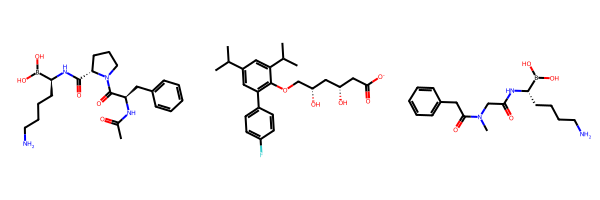

In [47]:
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice

molecules = [Chem.MolFromSmiles(smiles) for smiles in islice(data['smiles'], 3)]

Draw.MolsToGridImage(molecules)

### Curation 

The next step is to address the case where we have multiple measurements for a single structure (by RDkit canonical SMILEs string). We have a function in the `curate_data()` module to address the processing of compounds. The function parameters are listed below along with an explanation of each parameter:

In [45]:
data

,identifier,conf_id,smiles,charge,unpaired_electrons,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,lowest_wavenumber,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,SASA,PINT,rdkit_smiles,inchi_key
0,CHEMBL100109_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)[C@@]1([H])N(...,0,0,432.254401,64,31,10,15,3,2,6,5,-0.00,-95.217686,-80.857923,-14.359763,-94.654245,-94.751769,-0.770,4.382,2.623,5.163,-5.634,-16.989,-1.067,7.584,5.833,6.701,0.005391,0.004052,0.002753,19167.821,888.752,1481.254,21537.827,117.381,2.981,4.968,125.331,124.656,36.539,44.062,205.257,-0.358569,-0.230014,0.128555,-0.294291,38918.753715,299.145313,-1438.825592,-1427.937704,-10.887888,-1.171546,4.634069,2.296231,5.302810,0.005375,0.004012,0.002735,-138.525916,3355.285591,-8634.920890,3979.399032,-0.306544,0.052682,0.359226,17.830416604829175|1.500035048078731|12.859508...,31.810941695385928|43.45386310879664|36.710613...,CC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[...,UCQIHCRMWNRFNP-QYZOEREBSA-N
1,CHEMBL100165_charged,conf_00,[H]O[C@]([H])(C([H])([H])Oc1c(-c2c([H])c([H])c...,-1,0,417.208276,60,30,6,16,2,2,5,2,-0.00,-92.040600,-78.300971,-13.739630,-91.522251,-91.615446,-30.222,-10.375,-5.497,32.425,-107.789,-92.779,19.711,-30.939,-16.712,88.078,0.005772,0.002733,0.002005,17907.279,888.752,1481.254,20277.286,110.904,2.981,4.968,118.853,115.009,37.177,43.958,196.144,-0.202588,-0.186593,0.015995,-0.194590,36835.752182,292.629873,-1407.230554,-1396.727039,-10.503515,-27.847860,-10.546402,-4.587879,30.129364,0.005500,0.002677,0.001942,-134.485202,2939.123241,-7785.870908,3574.054238,-0.138897,0.098425,0.237322,14.630341835594542|0.03000070096157006|14.5303...,32.777081219883705|42.296161885126466|33.17706...,CC(C)c1cc(-c2ccc(F)cc2)c(OC[C@@H](O)C[C@@H](O)...,GWJDCGLHTDEKGT-UXHICEINSA-M
2,CHEMBL100187_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)C([H])([H])N(...,0,0,335.201637,50,24,8,14,1,1,5,4,-0.00,-73.906226,-62.763631,-11.142595,-73.466572,-73.548831,-0.229,-2.066,4.044,4.547,6.796,14.249,-1.423,3.390,-3.470,-5.373,0.008511,0.006594,0.004295,14601.451,888.752,1481.254,16971.458,90.305,2.981,4.968,98.254,94.665,35.159,43.304,173.128,-0.360990,-0.234921,0.126069,-0.297955,23810.766910,235.501526,-1114.389606,-1105.930661,-8.458944,-0.540481,-1.866552,4.430111,4.837564,0.008195,0.006572,0.004217,-107.301959,2196.826820,-5884.615344,2680.746914,-0.308022,0.044325,0.352346,11.070258654821028|1.0499888650789475|8.060188...,36.4255470210142|44.39135498757223|35.27951806...,CN(CC(=O)N[C@@H](CCCCN)B(O)O)C(=O)Cc1ccccc1,VPLBUOGKJQGYQO-AWEZNQCLSA-N
3,CHEMBL100188_charged,conf_00,[H]O[C@]([H])(/C([H])=C(\[H])C(=C(c1c([H])c([H...,-1,0,475.235079,66,35,8,16,2,3,8,2,-0.00,-101.824819,-86.110692,-15.714127,-101.263070,-101.362645,-11.750,0.330,0.699,11.776,-17.685,-4.103,-8.452,3.176,6.311,26.136,0.005057,0.003291,0.002408,20380.486,888.752,1481.254,22750.493,126.688,2.981,4.968,134.637,128.286,36.942,44.346,209.573,-0.230230,-0.159973,0.070257,-0.195102,49557.89831

In [320]:
data['compound_id'] = data['inchi_key']

In [322]:
# look at length of dataset and duplicates.
print('Compound name duplicates:', data['compound_id'].duplicated().sum())
print('SMILES duplicates:', data.rdkit_smiles.duplicated().sum())
print('Shape:',data.shape)

Compound name duplicates: 24
SMILES duplicates: 4
Shape: (27082, 73)


In [340]:
# column: Response values column
column = 'DFT_HOMO_LUMO_GAP'

# tolerance: Percentage of individual respsonse values allowed to be different 
# from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# call the method `average_and_remove_duplicates` which changes the data and returns
# the new object as curated_df, in this case
 

curated_df = curate_data.average_and_remove_duplicates(column, 
                                                       tolerance, 
                                                       list_bad_duplicates, 
                                                       data, 
                                                       max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (27082, 77)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, DFT_HOMO_LUMO_GAP, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (27078, 77)
New column created with averaged values:  VALUE_NUM_mean


In [408]:
# look at length of dataset and duplicates.
print('Compound id duplicates:', curated_df['compound_id'].duplicated().sum())
print('SMILES duplicates:', curated_df.rdkit_smiles.duplicated().sum())
print('Shape:', curated_df.shape)

Compound id duplicates: 23
SMILES duplicates: 0
Shape: (27078, 77)


In [410]:
curated_df.head(2)

,identifier,conf_id,smiles,charge,unpaired_electrons,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,lowest_wavenumber,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,SASA,PINT,rdkit_smiles,inchi_key,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,CHEMBL100109_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)[C@@]1([H])N(...,0,0,432.254401,64,31,10,15,3,2,6,5,-0.0,-95.217686,-80.857923,-14.359763,-94.654245,-94.751769,-0.770,4.382,2.623,5.163,-5.634,-16.989,-1.067,7.584,5.833,6.701,0.005391,0.004052,0.002753,19167.821,888.752,1481.254,21537.827,117.381,2.981,4.968,125.331,124.656,36.539,44.062,205.257,-0.358569,-0.230014,0.128555,-0.294291,38918.753715,299.145313,-1438.825592,-1427.937704,-10.887888,-1.171546,4.634069,2.296231,5.302810,0.005375,0.004012,0.002735,-138.525916,3355.285591,-8634.920890,3979.399032,-0.306544,0.052682,0.359226,17.830416604829175|1.500035048078731|12.859508...,31.810941695385928|43.45386310879664|36.710613...,CC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[...,UCQIHCRMWNRFNP-QYZOEREBSA-N,UCQIHCRMWNRFNP-QYZOEREBSA-N,0.359226,NaN,0.0,0
1,CHEMBL100165_charged,conf_00,[H]O[C@]([H])(C([H])([H])Oc1c(-c2c([H])c([H])c...,-1,0,417.208276,60,30,6,16,2,2,5,2,-0.0,-92.040600,-78.300971,-13.739630,-91.522251,-91.615446,-30.222,-10.375,-5.497,32.425,-107.789,-92.779,19.711,-30.939,-16.712,88.078,0.005772,0.002733,0.002005,17907.279,888.752,1481.254,20277.286,110.904,2.981,4.968,118.853,115.009,37.177,43.958,196.144,-0.202588,-0.186593,0.015995,-0.194590,36835.752182,292.629873,-1407.230554,-1396.727039,-10.503515,-27.847860,-10.546402,-4.587879,30.129364,0.005500,0.002677,0.001942,-134.485202,2939.123241,-7785.870908,3574.054238,-0.138897,0.098425,0.237322,14.630341835594542|0.03000070096157006|14.5303...,32.777081219883705|42.296161885126466|33.17706...,CC(C)c1cc(-c2ccc(F)cc2)c(OC[C@@H](O)C[C@@H](O)...,GWJDCGLHTDEKGT-UXHICEINSA-M,GWJDCGLHTDEKGT-UXHICEINSA-M,0.237322,NaN,0.0,0


In [415]:
# Find duplicated rows
duplicates = curated_df['compound_id'].duplicated(keep=False) # keep=False marks all duplicates as True
duplicated_rows = curated_df[duplicates]

In [411]:
# Calculate the mean of 'gap' for each 'id'
gap_means = curated_df.groupby('compound_id')['DFT_HOMO_LUMO_GAP'].mean().reset_index(name='avg_gap')

# Merge the average gap values back into the original DataFrame
curated_df = pd.merge(curated_df, gap_means, on='compound_id')

# Drop duplicates based on 'id' while keeping the first occurrence
curated_df = curated_df.drop_duplicates('compound_id').reset_index(drop=True)
curated_df.drop('avg_gap', axis=1, inplace=True)

In [416]:
curated_df.shape

(27055, 77)

In [418]:
del_features = ['Perc_Var', 'Remove_BadDuplicate']
curated_df.drop(labels=del_features, axis=1, inplace=True)

In [419]:
curated_df

,identifier,conf_id,smiles,charge,unpaired_electrons,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,lowest_wavenumber,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,SASA,PINT,rdkit_smiles,inchi_key,compound_id,VALUE_NUM_mean,VALUE_NUM_std
0,CHEMBL100109_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)[C@@]1([H])N(...,0,0,432.254401,64,31,10,15,3,2,6,5,-0.00,-95.217686,-80.857923,-14.359763,-94.654245,-94.751769,-0.770,4.382,2.623,5.163,-5.634,-16.989,-1.067,7.584,5.833,6.701,0.005391,0.004052,0.002753,19167.821,888.752,1481.254,21537.827,117.381,2.981,4.968,125.331,124.656,36.539,44.062,205.257,-0.358569,-0.230014,0.128555,-0.294291,38918.753715,299.145313,-1438.825592,-1427.937704,-10.887888,-1.171546,4.634069,2.296231,5.302810,0.005375,0.004012,0.002735,-138.525916,3355.285591,-8634.920890,3979.399032,-0.306544,0.052682,0.359226,17.830416604829175|1.500035048078731|12.859508...,31.810941695385928|43.45386310879664|36.710613...,CC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[...,UCQIHCRMWNRFNP-QYZOEREBSA-N,UCQIHCRMWNRFNP-QYZOEREBSA-N,0.359226,NaN
1,CHEMBL100165_charged,conf_00,[H]O[C@]([H])(C([H])([H])Oc1c(-c2c([H])c([H])c...,-1,0,417.208276,60,30,6,16,2,2,5,2,-0.00,-92.040600,-78.300971,-13.739630,-91.522251,-91.615446,-30.222,-10.375,-5.497,32.425,-107.789,-92.779,19.711,-30.939,-16.712,88.078,0.005772,0.002733,0.002005,17907.279,888.752,1481.254,20277.286,110.904,2.981,4.968,118.853,115.009,37.177,43.958,196.144,-0.202588,-0.186593,0.015995,-0.194590,36835.752182,292.629873,-1407.230554,-1396.727039,-10.503515,-27.847860,-10.546402,-4.587879,30.129364,0.005500,0.002677,0.001942,-134.485202,2939.123241,-7785.870908,3574.054238,-0.138897,0.098425,0.237322,14.630341835594542|0.03000070096157006|14.5303...,32.777081219883705|42.296161885126466|33.17706...,CC(C)c1cc(-c2ccc(F)cc2)c(OC[C@@H](O)C[C@@H](O)...,GWJDCGLHTDEKGT-UXHICEINSA-M,GWJDCGLHTDEKGT-UXHICEINSA-M,0.237322,NaN
2,CHEMBL100187_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)C([H])([H])N(...,0,0,335.201637,50,24,8,14,1,1,5,4,-0.00,-73.906226,-62.763631,-11.142595,-73.466572,-73.548831,-0.229,-2.066,4.044,4.547,6.796,14.249,-1.423,3.390,-3.470,-5.373,0.008511,0.006594,0.004295,14601.451,888.752,1481.254,16971.458,90.305,2.981,4.968,98.254,94.665,35.159,43.304,173.128,-0.360990,-0.234921,0.126069,-0.297955,23810.766910,235.501526,-1114.389606,-1105.930661,-8.458944,-0.540481,-1.866552,4.430111,4.837564,0.008195,0.006572,0.004217,-107.301959,2196.826820,-5884.615344,2680.746914,-0.308022,0.044325,0.352346,11.070258654821028|1.0499888650789475|8.060188...,36.4255470210142|44.39135498757223|35.27951806...,CN(CC(=O)N[C@@H](CCCCN)B(O)O)C(=O)Cc1ccccc1,VPLBUOGKJQGYQO-AWEZNQCLSA-N,VPLBUOGKJQGYQO-AWEZNQCLSA-N,0.352346,NaN
3,CHEMBL100188_charged,conf_00,[H]O[C@]([H])(/C([H])=C(\[H])C(=C(c1c([H])c([H...,-1,0,475.235079,66,35,8,16,2,3,8,2,-0.00,-101.824819,-86.110692,-15.714127,-101.263070,-101.362645,-11.750,0.330,0.699,11.776,-17.685,-4.103,-8.452,3.176,6.311,26.136,0.005057

Then, we could filter large compounds. In general, molecular weight >2000 is removed.

In [76]:
# filter out high MWs
mw_outlier = curated_df[curated_df.mw > 2000]
mw_outlier.shape

(0, 74)

We do not detect compounds with high mw(>2000).

In [433]:
curated_df.to_csv('qmugs11_curated.csv', index = False)

### EDA

Before modeling, we could conduct eda to have a general understanding of the dataset.

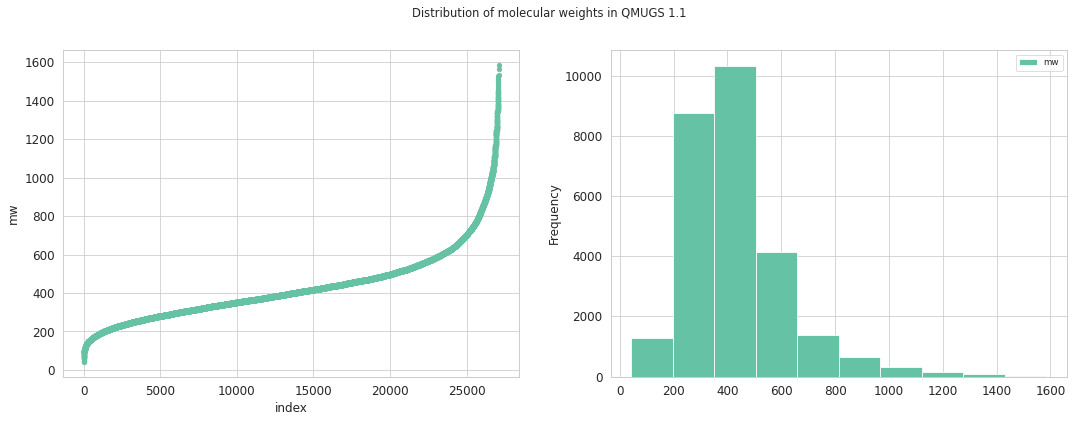

In [69]:
# visualize distribution of molecular weights
plot_df=curated_df
plot_df=plot_df.sort_values(by='mw')
plot_df=plot_df.reset_index(drop=True)
plot_df=plot_df.reset_index()

fig,ax=plt.subplots(1,2, figsize=(18,6))
plot_df.plot(kind='scatter', x='index', y='mw', color = pal[0], ax=ax[0])
plot_df.plot(kind='hist', x="index", y="mw", color = pal[0], ax=ax[1])
fig.suptitle("Distribution of molecular weights in QMUGS 1.1");

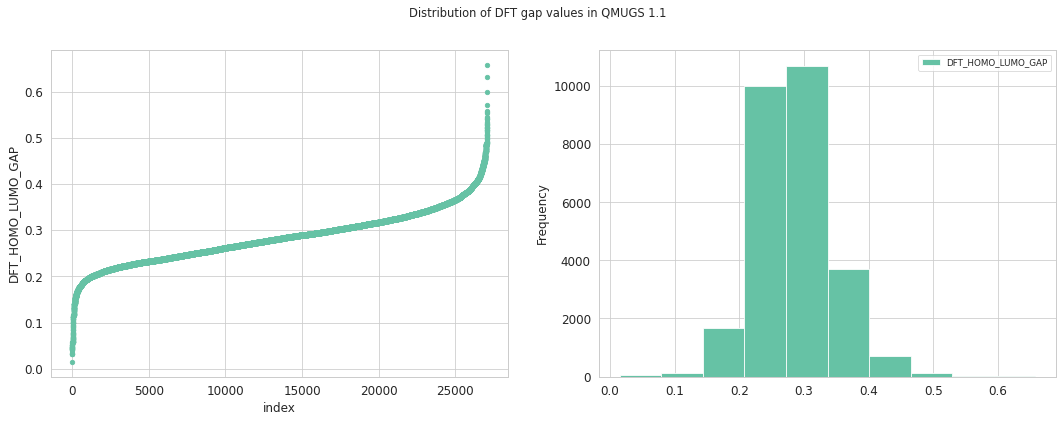

In [79]:
# visualize distribution of dft gap values
plot_df=curated_df
plot_df=plot_df.sort_values(by='DFT_HOMO_LUMO_GAP')
plot_df=plot_df.reset_index(drop=True)
plot_df=plot_df.reset_index()

fig,ax=plt.subplots(1,2, figsize=(18,6))
plot_df.plot(kind='scatter', x='index', y='DFT_HOMO_LUMO_GAP', color = pal[0], ax=ax[0])
plot_df.plot(kind='hist', x="index", y="DFT_HOMO_LUMO_GAP", color = pal[0], ax=ax[1])
fig.suptitle("Distribution of DFT gap values in QMUGS 1.1");

In [95]:
# recast the column as numeric
numeric_cols=['atoms','mw','heavy_atoms','heteroatoms',
              'rotatable_bonds','stereocenters','rings',
              'hbond_acceptors','hbond_donors',
              'GFN2_HOMO_LUMO_GAP','DFT_HOMO_LUMO_GAP']
for col in numeric_cols:
    curated_df[col]=curated_df[col].astype(float)

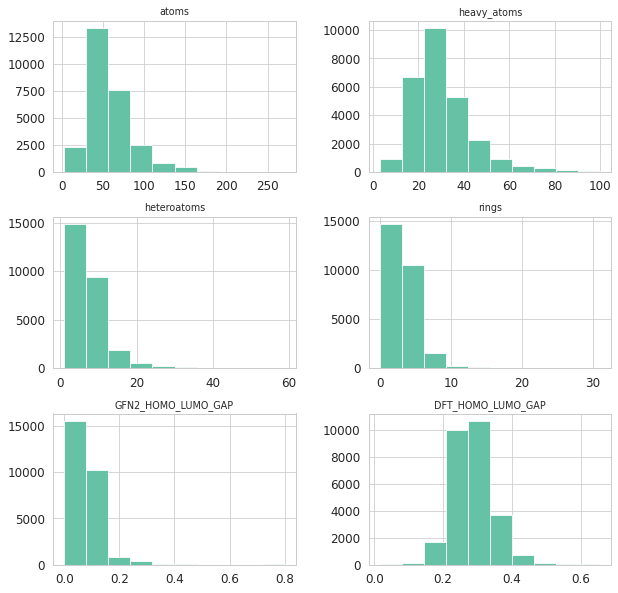

In [94]:
plot_cols = ['atoms','heavy_atoms','heteroatoms','rings',
             'GFN2_HOMO_LUMO_GAP','DFT_HOMO_LUMO_GAP']

curated_df[plot_cols].hist(figsize=(10,10));

We could also compare qmugs1.1 with qmugs

In [88]:
qmugs_data = pd.read_csv('final_data.csv', header = 0)

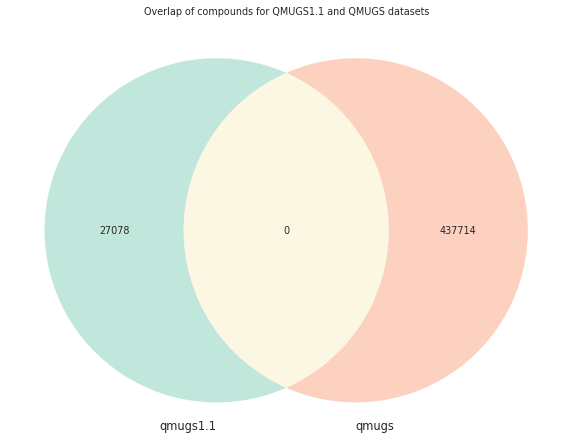

In [87]:
mpv.venn2_unweighted([set(curated_df["rdkit_smiles"]), set(qmugs_data["rdkit_smiles"])], set_labels = ("qmugs1.1", "qmugs"), set_colors = (pal[0], pal[1]))
plt.title('Overlap of compounds for QMUGS1.1 and QMUGS datasets');

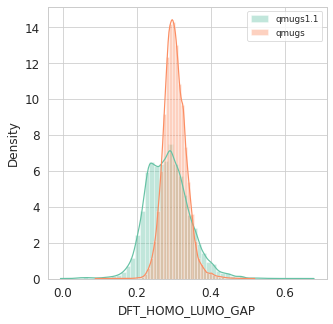

In [101]:
# compare dft gap values across qmugs1.1 and qmugs
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(curated_df.DFT_HOMO_LUMO_GAP, ax=ax, label = 'qmugs1.1')
sns.distplot(qmugs_data.DFT_HOMO_LUMO_GAP, ax=ax, label = 'qmugs')
plt.legend();

### EDA with division of data

We first identify percentiles and then split the dataset. Our objective is to seek for potential trends in dft gap value across different percentiles of mw, ring count, # of heavy atoms, and # of heteroatoms.

In [108]:
def find_percentile(data):
    # Calculating percentiles
    p25 = np.percentile(data, 25)
    p50 = np.percentile(data, 50)  # This is also the median
    p75 = np.percentile(data, 75)

    # Finding min and max
    min_value = np.min(data)
    max_value = np.max(data)

    return {
        "25th": round(p25,2),
        "Median": round(p50,2),
        "75th": round(p75,),
        "Minimum": round(min_value,2),
        "Maximum": round(max_value,2)
    }

In [119]:
name = ['mw','rings','heavy_atoms','heteroatoms']
for i in range(len(name)):
    print(f'{name[i]}: {find_percentile(curated_df[name[i]])}')


mw: {'25th': 306.21, 'Median': 398.12, '75th': 504, 'Minimum': 43.03, 'Maximum': 1585.08}
rings: {'25th': 2.0, 'Median': 3.0, '75th': 5, 'Minimum': 0.0, 'Maximum': 31.0}
heavy_atoms: {'25th': 22.0, 'Median': 28.0, '75th': 36, 'Minimum': 3.0, 'Maximum': 100.0}
heteroatoms: {'25th': 4.0, 'Median': 6.0, '75th': 9, 'Minimum': 1.0, 'Maximum': 59.0}


In [121]:
# split dataset based on percentile of given variable
def split(df,column):
    # compute percentile
    p25 = column.quantile(0.25)
    p50 = column.quantile(0.50)
    p75 = column.quantile(0.75)

    # Splitting the dataset based on percentile ranges
    lower = df[column <= p25]
    mid = df[(column > p25) & (column <= p50)]
    upper = df[(column > p50) & (column <= p75)]
    top = df[column > p75]

    return lower,mid,upper,top

In [169]:
# mw
mw_lower,mw_mid,mw_upper,mw_top = split(data, data['mw'])
# rings
ring_lower,ring_mid,ring_upper,ring_top = split(data, data['rings'])
# heavy atoms
heavy_atoms_lower,heavy_atoms_mid,heavy_atoms_upper,heavy_atoms_top = split(data, data['heavy_atoms'])
# heteroatoms
heteroatoms_lower,heteroatoms_mid,heteroatoms_upper,heteroatoms_top = split(data, data['heteroatoms'])

After identified the percentiles and splitted the dataset, we want to look at ring count first.


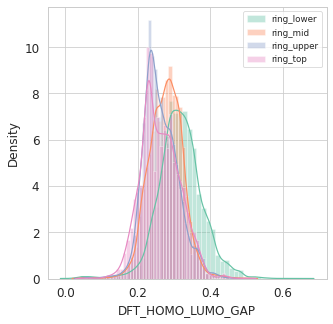

In [170]:
# compare dft gap values across qmugs1.1 and qmugs
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(ring_lower.DFT_HOMO_LUMO_GAP, ax=ax, label = 'ring_lower')
sns.distplot(ring_mid.DFT_HOMO_LUMO_GAP, ax=ax, label = 'ring_mid')
sns.distplot(ring_upper.DFT_HOMO_LUMO_GAP, ax=ax, label = 'ring_upper')
sns.distplot(ring_top.DFT_HOMO_LUMO_GAP, ax=ax, label = 'ring_top')

plt.legend();

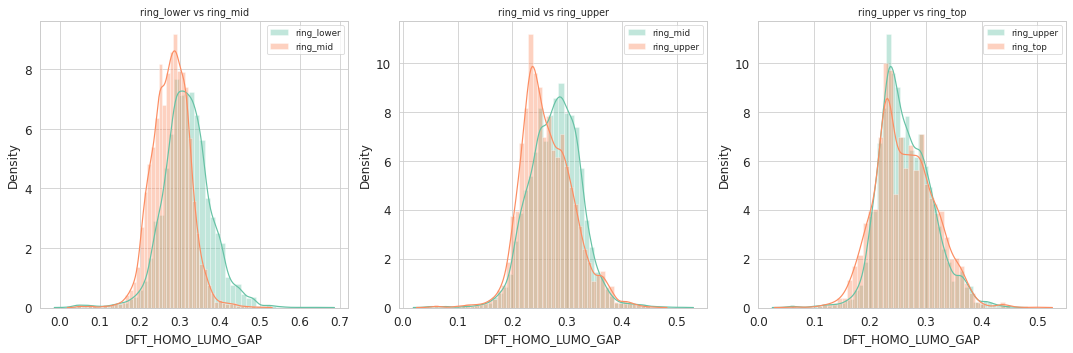

In [171]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Compare lower to mid
sns.distplot(ring_lower.DFT_HOMO_LUMO_GAP, ax=axes[0], label='ring_lower')
sns.distplot(ring_mid.DFT_HOMO_LUMO_GAP, ax=axes[0], label='ring_mid')
axes[0].legend()
axes[0].set_title('ring_lower vs ring_mid')

# Compare mid to upper
sns.distplot(ring_mid.DFT_HOMO_LUMO_GAP, ax=axes[1], label='ring_mid')
sns.distplot(ring_upper.DFT_HOMO_LUMO_GAP, ax=axes[1], label='ring_upper')
axes[1].legend()
axes[1].set_title('ring_mid vs ring_upper')

# Compare upper to top
sns.distplot(ring_upper.DFT_HOMO_LUMO_GAP, ax=axes[2], label='ring_upper')
sns.distplot(ring_top.DFT_HOMO_LUMO_GAP, ax=axes[2], label='ring_top')
axes[2].legend()
axes[2].set_title('ring_upper vs ring_top')

plt.tight_layout()
plt.show()

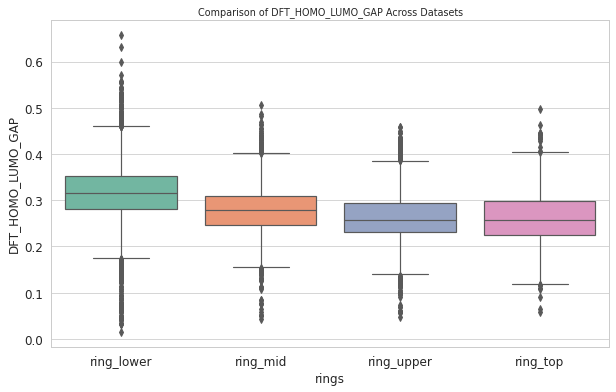

In [172]:
ring_lower['dataset'] = 'ring_lower'
ring_mid['dataset'] = 'ring_mid'
ring_upper['dataset'] = 'ring_upper'
ring_top['dataset'] = 'ring_top'

ring_df = pd.concat([ring_lower, ring_mid, ring_upper, ring_top])

# Now use seaborn to create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='dataset', y='DFT_HOMO_LUMO_GAP', data=ring_df)

# Set the title and labels
plt.title('Comparison of DFT_HOMO_LUMO_GAP Across Datasets')
plt.xlabel('rings')
plt.ylabel('DFT_HOMO_LUMO_GAP')

plt.show()

We observe a decreasing trend in dft gap value as ring counts are larger.

Next, we could look at percentiles of molecular weight and its relationship with dft gap value.

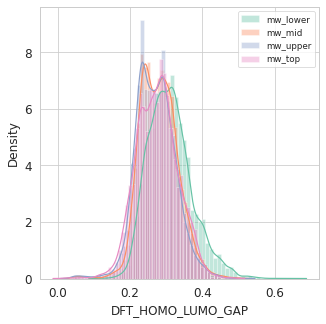

In [149]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(mw_lower.DFT_HOMO_LUMO_GAP, ax=ax, label = 'mw_lower')
sns.distplot(mw_mid.DFT_HOMO_LUMO_GAP, ax=ax, label = 'mw_mid')
sns.distplot(mw_upper.DFT_HOMO_LUMO_GAP, ax=ax, label = 'mw_upper')
sns.distplot(mw_top.DFT_HOMO_LUMO_GAP, ax=ax, label = 'mw_top')

plt.legend();

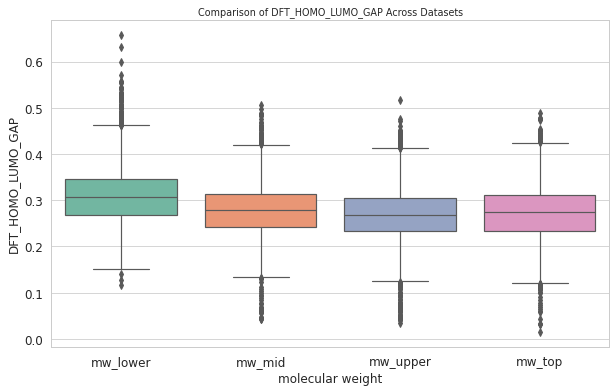

In [173]:
mw_lower['dataset'] = 'mw_lower'
mw_mid['dataset'] = 'mw_mid'
mw_upper['dataset'] = 'mw_upper'
mw_top['dataset'] = 'mw_top'

mw_df = pd.concat([mw_lower, mw_mid, mw_upper, mw_top])

# Now use seaborn to create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='dataset', y='DFT_HOMO_LUMO_GAP', data=mw_df)

# Set the title and labels
plt.title('Comparison of DFT_HOMO_LUMO_GAP Across Datasets')
plt.xlabel('molecular weight')
plt.ylabel('DFT_HOMO_LUMO_GAP')

plt.show()

Similar to ring count, we observe a decreasing trend in dft gap value. For the top 25 percentile, the gap value rises.

Furthermore, we could continue our exploration with number of heavy atoms.

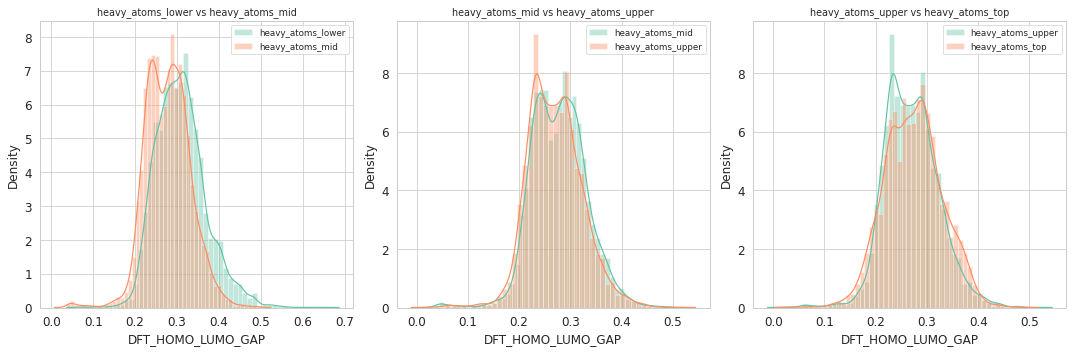

In [159]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Compare lower to mid
sns.distplot(heavy_atoms_lower.DFT_HOMO_LUMO_GAP, ax=axes[0], label='heavy_atoms_lower')
sns.distplot(heavy_atoms_mid.DFT_HOMO_LUMO_GAP, ax=axes[0], label='heavy_atoms_mid')
axes[0].legend()
axes[0].set_title('heavy_atoms_lower vs heavy_atoms_mid')

# Compare mid to upper
sns.distplot(heavy_atoms_mid.DFT_HOMO_LUMO_GAP, ax=axes[1], label='heavy_atoms_mid')
sns.distplot(heavy_atoms_upper.DFT_HOMO_LUMO_GAP, ax=axes[1], label='heavy_atoms_upper')
axes[1].legend()
axes[1].set_title('heavy_atoms_mid vs heavy_atoms_upper')

# Compare upper to top
sns.distplot(heavy_atoms_upper.DFT_HOMO_LUMO_GAP, ax=axes[2], label='heavy_atoms_upper')
sns.distplot(heavy_atoms_top.DFT_HOMO_LUMO_GAP, ax=axes[2], label='heavy_atoms_top')
axes[2].legend()
axes[2].set_title('heavy_atoms_upper vs heavy_atoms_top')

plt.tight_layout()
plt.show()

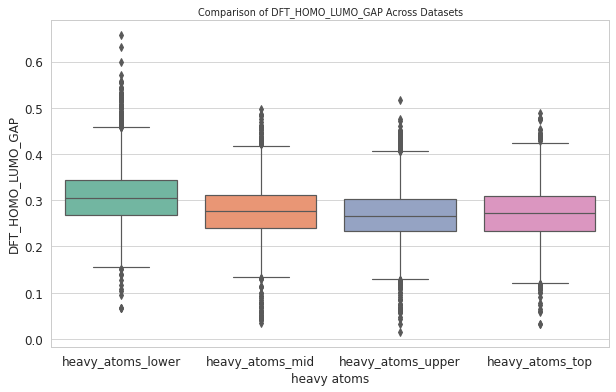

In [174]:
heavy_atoms_lower['dataset'] = 'heavy_atoms_lower'
heavy_atoms_mid['dataset'] = 'heavy_atoms_mid'
heavy_atoms_upper['dataset'] = 'heavy_atoms_upper'
heavy_atoms_top['dataset'] = 'heavy_atoms_top'

heavy_atoms_df = pd.concat([heavy_atoms_lower, heavy_atoms_mid, heavy_atoms_upper, heavy_atoms_top])

# Now use seaborn to create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='dataset', y='DFT_HOMO_LUMO_GAP', data=heavy_atoms_df)

# Set the title and labels
plt.title('Comparison of DFT_HOMO_LUMO_GAP Across Datasets')
plt.xlabel('heavy atoms')
plt.ylabel('DFT_HOMO_LUMO_GAP')

plt.show()

Lastly, we could examine if similar trends appear to heteroatoms.

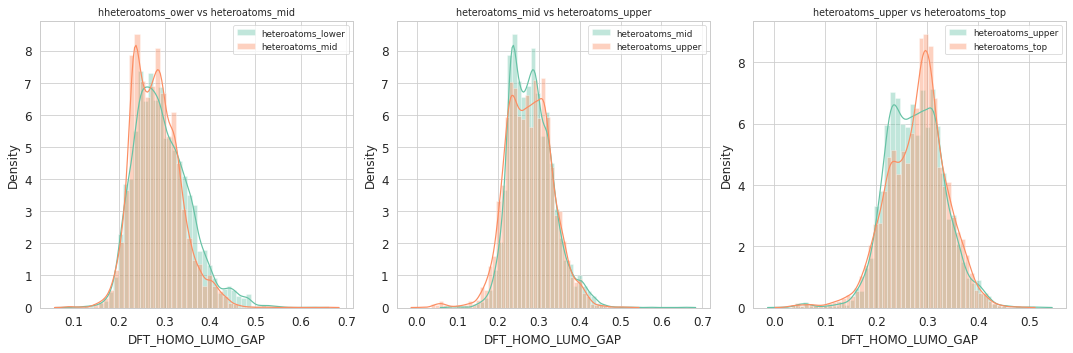

In [158]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Compare lower to mid
sns.distplot(heteroatoms_lower.DFT_HOMO_LUMO_GAP, ax=axes[0], label='heteroatoms_lower')
sns.distplot(heteroatoms_mid.DFT_HOMO_LUMO_GAP, ax=axes[0], label='heteroatoms_mid')
axes[0].legend()
axes[0].set_title('hheteroatoms_ower vs heteroatoms_mid')

# Compare mid to upper
sns.distplot(heteroatoms_mid.DFT_HOMO_LUMO_GAP, ax=axes[1], label='heteroatoms_mid')
sns.distplot(heteroatoms_upper.DFT_HOMO_LUMO_GAP, ax=axes[1], label='heteroatoms_upper')
axes[1].legend()
axes[1].set_title('heteroatoms_mid vs heteroatoms_upper')

# Compare upper to top
sns.distplot(heteroatoms_upper.DFT_HOMO_LUMO_GAP, ax=axes[2], label='heteroatoms_upper')
sns.distplot(heteroatoms_top.DFT_HOMO_LUMO_GAP, ax=axes[2], label='heteroatoms_top')
axes[2].legend()
axes[2].set_title('heteroatoms_upper vs heteroatoms_top')

plt.tight_layout()
plt.show()

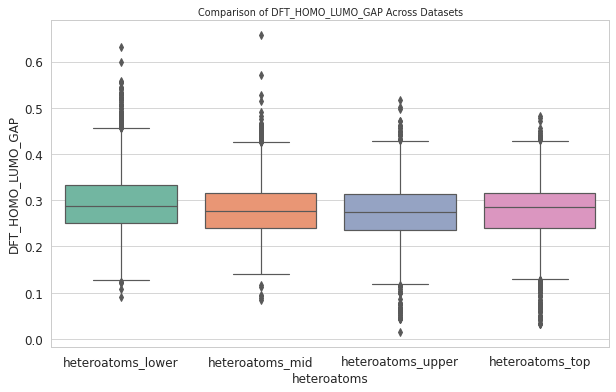

In [175]:
heteroatoms_lower['dataset'] = 'heteroatoms_lower'
heteroatoms_mid['dataset'] = 'heteroatoms_mid'
heteroatoms_upper['dataset'] = 'heteroatoms_upper'
heteroatoms_top['dataset'] = 'heteroatoms_top'

heteroatoms_df = pd.concat([heteroatoms_lower, heteroatoms_mid, heteroatoms_upper, heteroatoms_top])

# Now use seaborn to create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='dataset', y='DFT_HOMO_LUMO_GAP', data=heteroatoms_df)

# Set the title and labels
plt.title('Comparison of DFT_HOMO_LUMO_GAP Across Datasets')
plt.xlabel('heteroatoms')
plt.ylabel('DFT_HOMO_LUMO_GAP')

plt.show()

The differences in dft gap value across four percentiles is small with heteroatoms compared to other features.

In addition, we could also compare same percentile across rings, mw, heavy atoms, heteroatoms

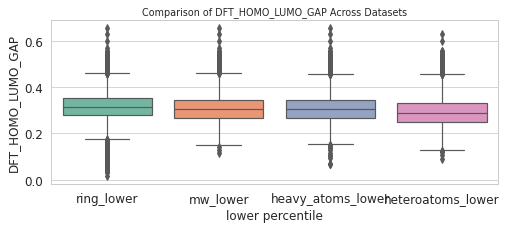

In [186]:
combine_lower_df = pd.concat([ring_lower, mw_lower, heavy_atoms_lower, heteroatoms_lower])

# Now use seaborn to create a boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(x='dataset', y='DFT_HOMO_LUMO_GAP', data=combine_lower_df)

# Set the title and labels
plt.title('Comparison of DFT_HOMO_LUMO_GAP Across Datasets')
plt.xlabel('lower percentile')
plt.ylabel('DFT_HOMO_LUMO_GAP')

plt.show()

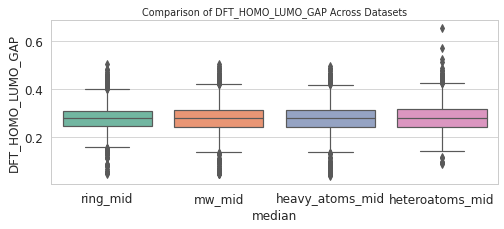

In [185]:
combine_mid_df = pd.concat([ring_mid,mw_mid,heavy_atoms_mid,heteroatoms_mid])

# Now use seaborn to create a boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(x='dataset', y='DFT_HOMO_LUMO_GAP', data=combine_mid_df)

# Set the title and labels
plt.title('Comparison of DFT_HOMO_LUMO_GAP Across Datasets')
plt.xlabel('median')
plt.ylabel('DFT_HOMO_LUMO_GAP')

plt.show()

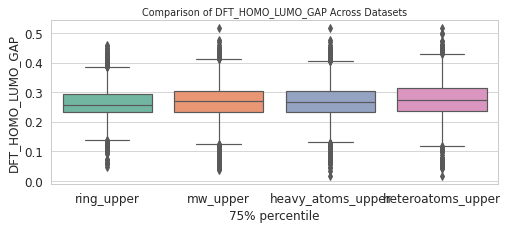

In [188]:
combine_upper_df = pd.concat([ring_upper,mw_upper,heavy_atoms_upper,heteroatoms_upper])

# Now use seaborn to create a boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(x='dataset', y='DFT_HOMO_LUMO_GAP', data=combine_upper_df)

# Set the title and labels
plt.title('Comparison of DFT_HOMO_LUMO_GAP Across Datasets')
plt.xlabel('75% percentile')
plt.ylabel('DFT_HOMO_LUMO_GAP')

plt.show()

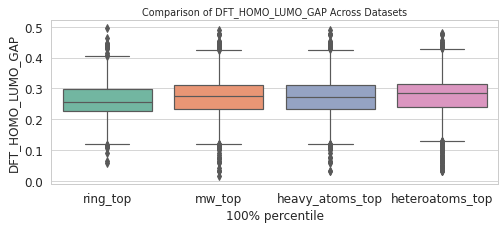

In [189]:
combine_top_df = pd.concat([ring_top,mw_top,heavy_atoms_top,heteroatoms_top])

# Now use seaborn to create a boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(x='dataset', y='DFT_HOMO_LUMO_GAP', data=combine_top_df)

# Set the title and labels
plt.title('Comparison of DFT_HOMO_LUMO_GAP Across Datasets')
plt.xlabel('100% percentile')
plt.ylabel('DFT_HOMO_LUMO_GAP')

plt.show()

We observe that the differences in dft gap values are small for all quantiles.

### Model prepareation

The first step is to search for number of functional groups present in each compound.

In [190]:
from rdkit.Chem import Draw, Descriptors, rdqueries
from rdkit.Chem import rdchem

### Determine which functional groups are wanted. Create SMARTS files for each functional group and label appropriately.

fg = Chem.MolFromSmarts('C(=O)[NX3;H2]')
#fx = Chem.MolFromSmarts('CC(=O)N[C@H]')
#fy = Chem.MolFromSmarts('CC(=O)O')
#fz = Chem.MolFromSmarts('O=C[O]')
#fw = Chem.MolFromSmarts('N[S](=O)=O')
#fm = Chem.MolFromSmarts('O=S=O')

famide = Chem.MolFromSmarts('CC(N)=O')
fcarbox = Chem.MolFromSmarts('CC(O)=O')
fsulfonyl = Chem.MolFromSmarts('CS(=O)(C)=O')
fsulfonamide = Chem.MolFromSmarts('NS(C)(=O)=O')
falc = Chem.MolFromSmarts('OC')
facrylate = Chem.MolFromSmarts('O=C([O])C=C')
faldehyde = Chem.MolFromSmarts('CC=O')
fmethoxyalcohol = Chem.MolFromSmarts('OC[O]')
fhydroxyacetamide = Chem.MolFromSmarts('O=C[N]O')
facrylamide = Chem.MolFromSmarts('O=C([N])C=C')
fcarbamate = Chem.MolFromSmarts('O=C([O])[N]')
foxyirane = Chem.MolFromSmarts('O1CC1')
f_allamide = Chem.MolFromSmarts('NC=O')

In [194]:
### Search rdkit_smiles from curated data to find molecules that the functional groups are located in.

curated_df["amides"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(famide)) for smile in curated_df["rdkit_smiles"]]
curated_df["carboxy"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fcarbox)) for smile in curated_df["rdkit_smiles"]]
curated_df["sulfonyl"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fsulfonyl)) for smile in curated_df["rdkit_smiles"]]
curated_df["sulfonamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fsulfonamide)) for smile in curated_df["rdkit_smiles"]]
curated_df["alcohol"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(falc)) for smile in curated_df["rdkit_smiles"]]
curated_df["acrylate"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(facrylate)) for smile in curated_df["rdkit_smiles"]]
curated_df["aldehyde"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(faldehyde)) for smile in curated_df["rdkit_smiles"]]
curated_df["methoxyalcohol"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fmethoxyalcohol)) for smile in curated_df["rdkit_smiles"]]
curated_df["hydroxyacetamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fhydroxyacetamide)) for smile in curated_df["rdkit_smiles"]]
curated_df["acrylamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(facrylamide)) for smile in curated_df["rdkit_smiles"]]
curated_df["carbamate"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fcarbamate)) for smile in curated_df["rdkit_smiles"]]
curated_df["oxyirane"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(foxyirane)) for smile in curated_df["rdkit_smiles"]]
curated_df["allamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(f_allamide)) for smile in curated_df["rdkit_smiles"]]
curated_df["amide_NH2"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(fg)) for smile in curated_df["rdkit_smiles"]]
curated_df["allamide"] = [len(Chem.MolFromSmiles(smile).GetSubstructMatch(f_allamide)) for smile in curated_df["rdkit_smiles"]]

In [213]:
fglist = ["amides","carboxy","sulfonyl", "sulfonamide", "alcohol","acrylate","aldehyde","methoxyalcohol","hydroxyacetamide","acrylamide","carbamate","oxyirane","allamide","amide_NH2"]

for i in fglist:
    print(f'{i}: {(curated_df[i]>0).sum()}')

amides: 5926
carboxy: 5830
sulfonyl: 219
sulfonamide: 303
alcohol: 16440
acrylate: 998
aldehyde: 11624
methoxyalcohol: 1945
hydroxyacetamide: 121
acrylamide: 472
carbamate: 875
oxyirane: 77
allamide: 8378
amide_NH2: 572


We exclude oxyirane(<100) for now.

In [218]:
# Make sure the compounds showing the functional groups have the functional groups present.
# First sort the dataframe based on the functional group you are interested in. Create a dataframe of that tail. And visualize the dataframe. 

amide_sorted = curated_df.sort_values("amides")
tail = amide_sorted.tail(10)

### Model testing
We first could test our original models generated from QMUGS. If we see similar results, we could say that the model is validated on a different dataset. If not, we could continue to train for our own model using selected featurizer and model type.

In [219]:
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data
from atomsci.ddm.pipeline import model_pipeline as mp
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp
from atomsci.ddm.pipeline import predict_from_model as pfm

In [231]:
curated_df.head()

,identifier,conf_id,smiles,charge,unpaired_electrons,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,lowest_wavenumber,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP,SASA,PINT,rdkit_smiles,inchi_key,VALUE_NUM_mean,VALUE_NUM_std,amides,carboxy,sulfonyl,sulfonamide,alcohol,acrylate,aldehyde,methoxyalcohol,hydroxyacetamide,acrylamide,carbamate,oxyirane,allamide,amide_NH2,orig_smiles
0,CHEMBL100109_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)[C@@]1([H])N(...,0,0,432.254401,64.0,31.0,10.0,15.0,3.0,2.0,6.0,5.0,-0.00,-95.217686,-80.857923,-14.359763,-94.654245,-94.751769,-0.770,4.382,2.623,5.163,-5.634,-16.989,-1.067,7.584,5.833,6.701,0.005391,0.004052,0.002753,19167.821,888.752,1481.254,21537.827,117.381,2.981,4.968,125.331,124.656,36.539,44.062,205.257,-0.358569,-0.230014,0.128555,-0.294291,38918.753715,299.145313,-1438.825592,-1427.937704,-10.887888,-1.171546,4.634069,2.296231,5.302810,0.005375,0.004012,0.002735,-138.525916,3355.285591,-8634.920890,3979.399032,-0.306544,0.052682,0.359226,17.830416604829175|1.500035048078731|12.859508...,31.810941695385928|43.45386310879664|36.710613...,CC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[...,UCQIHCRMWNRFNP-QYZOEREBSA-N,0.359226,NaN,4,0,0,0,0,0,3,0,0,0,0,0,3,0,CC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[...
1,CHEMBL100165_charged,conf_00,[H]O[C@]([H])(C([H])([H])Oc1c(-c2c([H])c([H])c...,-1,0,417.208276,60.0,30.0,6.0,16.0,2.0,2.0,5.0,2.0,-0.00,-92.040600,-78.300971,-13.739630,-91.522251,-91.615446,-30.222,-10.375,-5.497,32.425,-107.789,-92.779,19.711,-30.939,-16.712,88.078,0.005772,0.002733,0.002005,17907.279,888.752,1481.254,20277.286,110.904,2.981,4.968,118.853,115.009,37.177,43.958,196.144,-0.202588,-0.186593,0.015995,-0.194590,36835.752182,292.629873,-1407.230554,-1396.727039,-10.503515,-27.847860,-10.546402,-4.587879,30.129364,0.005500,0.002677,0.001942,-134.485202,2939.123241,-7785.870908,3574.054238,-0.138897,0.098425,0.237322,14.630341835594542|0.03000070096157006|14.5303...,32.777081219883705|42.296161885126466|33.17706...,CC(C)c1cc(-c2ccc(F)cc2)c(OC[C@@H](O)C[C@@H](O)...,GWJDCGLHTDEKGT-UXHICEINSA-M,0.237322,NaN,0,4,0,0,2,0,3,0,0,0,0,0,0,0,CC(C)c1cc(-c2ccc(F)cc2)c(OC[C@@H](O)C[C@@H](O)...
2,CHEMBL100187_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)C([H])([H])N(...,0,0,335.201637,50.0,24.0,8.0,14.0,1.0,1.0,5.0,4.0,-0.00,-73.906226,-62.763631,-11.142595,-73.466572,-73.548831,-0.229,-2.066,4.044,4.547,6.796,14.249,-1.423,3.390,-3.470,-5.373,0.008511,0.006594,0.004295,14601.451,888.752,1481.254,16971.458,90.305,2.981,4.968,98.254,94.665,35.159,43.304,173.128,-0.360990,-0.234921,0.126069,-0.297955,23810.766910,235.501526,-1114.389606,-1105.930661,-8.458944,-0.540481,-1.866552,4.430111,4.837564,0.008195,0.006572,0.004217,-107.301959,2196.826820,-5884.615344,2680.746914,-0.308022,0.044325,0.352346,11.070258654821028|1.0499888650789475|8.060188...,36.4255470210142|44.39135498757223|35.27951806...,CN(CC(=O)N[C@@H](CCCCN)B(O)O)C(=O)Cc1ccccc1,VPLBUOGKJQGYQO-AWEZNQCLSA-N,0.3523

In [263]:
data11 = data11[['identifier','conf_id','smiles','rdkit_smiles','inchi_key','compound_id','mw','atoms','heavy_atoms','heteroatoms','rotatable_bonds','stereocenters','rings',"amides","carboxy","sulfonyl", "sulfonamide", "alcohol","acrylate","aldehyde","methoxyalcohol","hydroxyacetamide","acrylamide","carbamate","oxyirane","allamide","amide_NH2",'GFN2_HOMO_LUMO_GAP','DFT_HOMO_LUMO_GAP']]

In [264]:
data11.head()

,identifier,conf_id,smiles,rdkit_smiles,inchi_key,compound_id,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,amides,carboxy,sulfonyl,sulfonamide,alcohol,acrylate,aldehyde,methoxyalcohol,hydroxyacetamide,acrylamide,carbamate,oxyirane,allamide,amide_NH2,GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP
0,CHEMBL100109_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)[C@@]1([H])N(...,CC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[...,UCQIHCRMWNRFNP-QYZOEREBSA-N,UCQIHCRMWNRFNP-QYZOEREBSA-N,432.254401,64.0,31.0,10.0,15.0,3.0,2.0,4,0,0,0,0,0,3,0,0,0,0,0,3,0,0.128555,0.359226
1,CHEMBL100165_charged,conf_00,[H]O[C@]([H])(C([H])([H])Oc1c(-c2c([H])c([H])c...,CC(C)c1cc(-c2ccc(F)cc2)c(OC[C@@H](O)C[C@@H](O)...,GWJDCGLHTDEKGT-UXHICEINSA-M,GWJDCGLHTDEKGT-UXHICEINSA-M,417.208276,60.0,30.0,6.0,16.0,2.0,2.0,0,4,0,0,2,0,3,0,0,0,0,0,0,0,0.015995,0.237322
2,CHEMBL100187_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)C([H])([H])N(...,CN(CC(=O)N[C@@H](CCCCN)B(O)O)C(=O)Cc1ccccc1,VPLBUOGKJQGYQO-AWEZNQCLSA-N,VPLBUOGKJQGYQO-AWEZNQCLSA-N,335.201637,50.0,24.0,8.0,14.0,1.0,1.0,4,0,0,0,0,0,3,0,0,0,0,0,3,0,0.126069,0.352346
3,CHEMBL100188_charged,conf_00,[H]O[C@]([H])(/C([H])=C(\[H])C(=C(c1c([H])c([H...,Cc1ccc(C(=C(/C=C/[C@@H](O)C[C@@H](O)CC(=O)[O-]...,UUVPDWUBKWQFOU-AZHXHMFBSA-M,UUVPDWUBKWQFOU-AZHXHMFBSA-M,475.235079,66.0,35.0,8.0,16.0,2.0,3.0,0,4,0,0,2,0,3,0,0,0,0,0,0,0,0.070257,0.294730
4,CHEMBL100201_charged,conf_00,[H]c1nc([H])c([C@@]2([H])SC([H])([H])c3c(C(=O)...,O=C(c1ccn2c1CS[C@@H]2c1cccnc1)c1cn(C(=O)c2cccc...,WSTGIXIJIWZIHP-MGBGTMOVSA-M,WSTGIXIJIWZIHP-MGBGTMOVSA-M,622.091215,65.0,44.0,11.0,6.0,1.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.090870,0.295396


Firstly, we use random split to split the data and train model with graphconv and ecfp featurizers.

In [265]:
# Random split, graphconv, NN
mfile = '/home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz'
mpath = '/content'
input_df = data11
response_col = "GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP"
compound_id = 'inchi_key'
smiles_col = "rdkit_smiles"
results_df = pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

Standardizing SMILES strings for 27078 compounds.


2024-03-03 21:51:36,286 Aborting reionization to avoid infinite loop due to it being ambiguous where to put a Hydrogen
2024-03-03 21:51:50,698 /home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz, 1.5.1
2024-03-03 21:51:50,713 Version compatible check: /home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz version = "1.5", AMPL version = "1.5"


num_model_tasks is deprecated and its value is ignored.


In [266]:
randgc_results_df = results_df

In [268]:
dft_actual = randgc_results_df['DFT_HOMO_LUMO_GAP'].values
dft_predict = randgc_results_df['DFT_HOMO_LUMO_GAP_pred'].values

corr_matrix_r2 = np.corrcoef(dft_actual, dft_predict)
corr_randgc_r2 = corr_matrix_r2[0,1]
dft_randgc_r2 = corr_randgc_r2 **2

print(dft_randgc_r2)

0.47697553256037806


In [269]:
randgc_results_df.head()

,identifier,conf_id,smiles,rdkit_smiles,inchi_key,compound_id,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,amides,carboxy,sulfonyl,sulfonamide,alcohol,acrylate,aldehyde,methoxyalcohol,hydroxyacetamide,acrylamide,carbamate,oxyirane,allamide,amide_NH2,GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP,orig_smiles,GFN2_HOMO_LUMO_GAP_pred,DFT_HOMO_LUMO_GAP_pred
0,CHEMBL100109_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)[C@@]1([H])N(...,CC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[...,UCQIHCRMWNRFNP-QYZOEREBSA-N,UCQIHCRMWNRFNP-QYZOEREBSA-N,432.254401,64.0,31.0,10.0,15.0,3.0,2.0,4,0,0,0,0,0,3,0,0,0,0,0,3,0,0.128555,0.359226,CC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[...,0.134004,0.357506
1,CHEMBL100165_charged,conf_00,[H]O[C@]([H])(C([H])([H])Oc1c(-c2c([H])c([H])c...,CC(C)c1cc(-c2ccc(F)cc2)c(OC[C@@H](O)C[C@@H](O)...,GWJDCGLHTDEKGT-UXHICEINSA-M,GWJDCGLHTDEKGT-UXHICEINSA-M,417.208276,60.0,30.0,6.0,16.0,2.0,2.0,0,4,0,0,2,0,3,0,0,0,0,0,0,0,0.015995,0.237322,CC(C)c1cc(-c2ccc(F)cc2)c(OC[C@@H](O)C[C@@H](O)...,0.123769,0.334581
2,CHEMBL100187_neutral,conf_00,[H]OB(O[H])[C@@]([H])(N([H])C(=O)C([H])([H])N(...,CN(CC(=O)N[C@@H](CCCCN)B(O)O)C(=O)Cc1ccccc1,VPLBUOGKJQGYQO-AWEZNQCLSA-N,VPLBUOGKJQGYQO-AWEZNQCLSA-N,335.201637,50.0,24.0,8.0,14.0,1.0,1.0,4,0,0,0,0,0,3,0,0,0,0,0,3,0,0.126069,0.352346,CN(CC(=O)N[C@@H](CCCCN)B(O)O)C(=O)Cc1ccccc1,0.132242,0.353814
3,CHEMBL100188_charged,conf_00,[H]O[C@]([H])(/C([H])=C(\[H])C(=C(c1c([H])c([H...,Cc1ccc(C(=C(/C=C/[C@@H](O)C[C@@H](O)CC(=O)[O-]...,UUVPDWUBKWQFOU-AZHXHMFBSA-M,UUVPDWUBKWQFOU-AZHXHMFBSA-M,475.235079,66.0,35.0,8.0,16.0,2.0,3.0,0,4,0,0,2,0,3,0,0,0,0,0,0,0,0.070257,0.294730,Cc1ccc(C(=C(/C=C/[C@@H](O)C[C@@H](O)CC(=O)[O-]...,0.091182,0.280734
4,CHEMBL100201_charged,conf_00,[H]c1nc([H])c([C@@]2([H])SC([H])([H])c3c(C(=O)...,O=C(c1ccn2c1CS[C@@H]2c1cccnc1)c1cn(C(=O)c2cccc...,WSTGIXIJIWZIHP-MGBGTMOVSA-M,WSTGIXIJIWZIHP-MGBGTMOVSA-M,622.091215,65.0,44.0,11.0,6.0,1.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.090870,0.295396,O=C(c1ccn2c1CS[C@@H]2c1cccnc1)c1cn(C(=O)c2cccc...,0.076465,0.285526


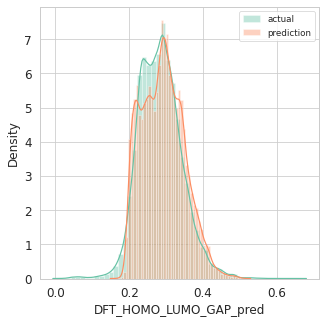

In [271]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(randgc_results_df.DFT_HOMO_LUMO_GAP, ax=ax, label = 'actual')
sns.distplot(randgc_results_df.DFT_HOMO_LUMO_GAP_pred, ax=ax, label = 'prediction')
plt.legend();

In [272]:
# Random split, ECFP, NN
mfile = '/home/jupyter/Models/select_qmugs_data_curated (2)_model_1271d6b8-ee81-474e-acc2-dd73fbc3f4ae.tar.gz'
mpath = '/content'
input_df = data11
response_col = "GFN2_HOMO_LUMO_GAP, DFT_HOMO_LUMO_GAP"
compound_id = 'compound_id'
smiles_col = "rdkit_smiles"
results_df = pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

Standardizing SMILES strings for 27078 compounds.


2024-03-03 21:56:52,006 Aborting reionization to avoid infinite loop due to it being ambiguous where to put a Hydrogen
2024-03-03 21:57:05,750 /home/jupyter/Models/select_qmugs_data_curated (2)_model_1271d6b8-ee81-474e-acc2-dd73fbc3f4ae.tar.gz, 1.5.1
2024-03-03 21:57:05,754 Version compatible check: /home/jupyter/Models/select_qmugs_data_curated (2)_model_1271d6b8-ee81-474e-acc2-dd73fbc3f4ae.tar.gz version = "1.5", AMPL version = "1.5"


num_model_tasks is deprecated and its value is ignored.
['/var/tmp/tmp6465jfvo/best_model/checkpoint1.pt']
/var/tmp/tmp6465jfvo/best_model/checkpoint1.pt


In [273]:
randecfp_results_df = results_df

In [274]:
dft_actual = randecfp_results_df['DFT_HOMO_LUMO_GAP'].values
dft_predict = randecfp_results_df['DFT_HOMO_LUMO_GAP_pred'].values

corr_matrix_r2 = np.corrcoef(dft_actual, dft_predict)
corr_randecfp_r2 = corr_matrix_r2[0,1]
dft_randecfp_r2 = corr_randecfp_r2 **2

print(dft_randecfp_r2)

0.5190106381014108


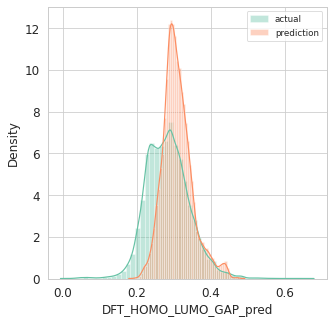

In [299]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(randecfp_results_df.DFT_HOMO_LUMO_GAP, ax=ax, label = 'actual')
sns.distplot(randecfp_results_df.DFT_HOMO_LUMO_GAP_pred, ax=ax, label = 'prediction')
plt.legend();

Next, we use fingerprint split with two graphconv and ecfp.

In [276]:
# Fingerprint split, graphconv, NN
mfile = '/home/jupyter/Models/select_qmugs_data_curated (2)_model_4e942a08-e9d6-4ac9-bfb4-277e0518ee2d.tar.gz'
mpath = '/content'
input_df = data11
response_col = "GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP"
compound_id = 'compound_id'
smiles_col = "rdkit_smiles"
results_df = pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

Standardizing SMILES strings for 27078 compounds.


2024-03-03 22:01:43,061 Aborting reionization to avoid infinite loop due to it being ambiguous where to put a Hydrogen
2024-03-03 22:01:56,112 /home/jupyter/Models/select_qmugs_data_curated (2)_model_4e942a08-e9d6-4ac9-bfb4-277e0518ee2d.tar.gz, 1.5.1
2024-03-03 22:01:56,116 Version compatible check: /home/jupyter/Models/select_qmugs_data_curated (2)_model_4e942a08-e9d6-4ac9-bfb4-277e0518ee2d.tar.gz version = "1.5", AMPL version = "1.5"


num_model_tasks is deprecated and its value is ignored.


In [277]:
fingergc_results_df = results_df

In [278]:
dft_actual = fingergc_results_df['DFT_HOMO_LUMO_GAP'].values
dft_predict = fingergc_results_df['DFT_HOMO_LUMO_GAP_pred'].values

corr_matrix_r2 = np.corrcoef(dft_actual, dft_predict)
corr_fingergc_r2 = corr_matrix_r2[0,1]
dft_fingergc_r2 = corr_fingergc_r2 **2

print(dft_fingergc_r2)

0.5434207416251976


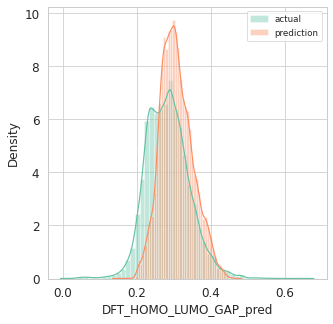

In [279]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(fingergc_results_df.DFT_HOMO_LUMO_GAP, ax=ax, label = 'actual')
sns.distplot(fingergc_results_df.DFT_HOMO_LUMO_GAP_pred, ax=ax, label = 'prediction')
plt.legend();

In [280]:
# Fingerprint split, ECFP, NN
mfile = '/home/jupyter/Models/select_qmugs_data_curated (2)_model_285356d8-0b65-4925-a8f6-ccb605d5136b.tar.gz'
mpath = '/content'
input_df = data11
response_col = "GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP"
compound_id = 'compound_id'
smiles_col = "rdkit_smiles"
results_df = pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

Standardizing SMILES strings for 27078 compounds.


2024-03-03 22:07:15,699 Aborting reionization to avoid infinite loop due to it being ambiguous where to put a Hydrogen
2024-03-03 22:07:28,218 /home/jupyter/Models/select_qmugs_data_curated (2)_model_285356d8-0b65-4925-a8f6-ccb605d5136b.tar.gz, 1.5.1
2024-03-03 22:07:28,224 Version compatible check: /home/jupyter/Models/select_qmugs_data_curated (2)_model_285356d8-0b65-4925-a8f6-ccb605d5136b.tar.gz version = "1.5", AMPL version = "1.5"


num_model_tasks is deprecated and its value is ignored.
['/var/tmp/tmp57n7098g/best_model/checkpoint1.pt']
/var/tmp/tmp57n7098g/best_model/checkpoint1.pt


In [281]:
fingerecfp_results_df = results_df

In [282]:
dft_actual = fingerecfp_results_df['DFT_HOMO_LUMO_GAP'].values
dft_predict = fingerecfp_results_df['DFT_HOMO_LUMO_GAP_pred'].values

corr_matrix_r2 = np.corrcoef(dft_actual, dft_predict)
corr_fingerecfp_r2 = corr_matrix_r2[0,1]
dft_fingerecfp_r2 = corr_fingerecfp_r2 **2

print(dft_fingerecfp_r2)

0.4697743362057761


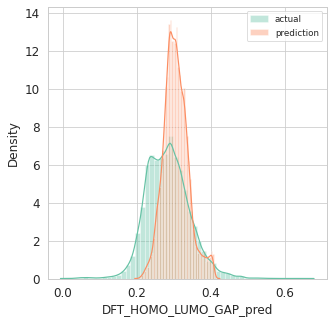

In [283]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(fingerecfp_results_df.DFT_HOMO_LUMO_GAP, ax=ax, label = 'actual')
sns.distplot(fingerecfp_results_df.DFT_HOMO_LUMO_GAP_pred, ax=ax, label = 'prediction')
plt.legend();

Finally, we continue to scaffold split.

In [284]:
# Scaffold split, graphconv, NN
mfile = '/home/jupyter/Models/select_qmugs_data_curated (2)_model_285356d8-0b65-4925-a8f6-ccb605d5136b.tar.gz'
mpath = '/content'
input_df = data11
response_col = "GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP"
compound_id = 'compound_id'
smiles_col = "rdkit_smiles"
results_df = pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

Standardizing SMILES strings for 27078 compounds.


2024-03-03 22:10:07,361 Aborting reionization to avoid infinite loop due to it being ambiguous where to put a Hydrogen
2024-03-03 22:10:19,516 /home/jupyter/Models/select_qmugs_data_curated (2)_model_285356d8-0b65-4925-a8f6-ccb605d5136b.tar.gz, 1.5.1
2024-03-03 22:10:19,520 Version compatible check: /home/jupyter/Models/select_qmugs_data_curated (2)_model_285356d8-0b65-4925-a8f6-ccb605d5136b.tar.gz version = "1.5", AMPL version = "1.5"


num_model_tasks is deprecated and its value is ignored.
['/var/tmp/tmp3dcxxqn5/best_model/checkpoint1.pt']
/var/tmp/tmp3dcxxqn5/best_model/checkpoint1.pt


In [285]:
scaffoldgc_results_df = results_df

In [286]:
dft_actual = scaffoldgc_results_df['DFT_HOMO_LUMO_GAP'].values
dft_predict = scaffoldgc_results_df['DFT_HOMO_LUMO_GAP_pred'].values

corr_matrix_r2 = np.corrcoef(dft_actual, dft_predict)
corr_scaffoldgc_r2 = corr_matrix_r2[0,1]
dft_scaffoldgc_r2 = corr_scaffoldgc_r2 **2

print(dft_scaffoldgc_r2)

0.4697777734193125


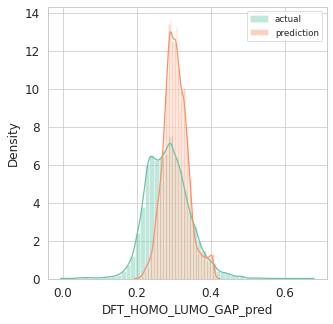

In [287]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(scaffoldgc_results_df.DFT_HOMO_LUMO_GAP, ax=ax, label = 'actual')
sns.distplot(scaffoldgc_results_df.DFT_HOMO_LUMO_GAP_pred, ax=ax, label = 'prediction')
plt.legend();

In [289]:
# Scaffold split, ECFP, NN
mfile = '/home/jupyter/Models/select_qmugs_data_curated (2)_model_5e947e95-3ae9-47df-a2ac-9d29066acc3c.tar.gz'
mpath = '/content'
input_df = data11
response_col = "GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP"
compound_id = 'compound_id'
smiles_col = "rdkit_smiles"
results_df = pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

Standardizing SMILES strings for 27078 compounds.


2024-03-03 22:12:24,438 Aborting reionization to avoid infinite loop due to it being ambiguous where to put a Hydrogen
2024-03-03 22:12:36,254 /home/jupyter/Models/select_qmugs_data_curated (2)_model_5e947e95-3ae9-47df-a2ac-9d29066acc3c.tar.gz, 1.5.1
2024-03-03 22:12:36,258 Version compatible check: /home/jupyter/Models/select_qmugs_data_curated (2)_model_5e947e95-3ae9-47df-a2ac-9d29066acc3c.tar.gz version = "1.5", AMPL version = "1.5"


num_model_tasks is deprecated and its value is ignored.
['/var/tmp/tmp6mhbxvze/best_model/checkpoint1.pt']
/var/tmp/tmp6mhbxvze/best_model/checkpoint1.pt


In [290]:
scaffoldecfp_results_df = results_df

In [291]:
dft_actual = scaffoldecfp_results_df['DFT_HOMO_LUMO_GAP'].values
dft_predict = scaffoldecfp_results_df['DFT_HOMO_LUMO_GAP_pred'].values

corr_matrix_r2 = np.corrcoef(dft_actual, dft_predict)
corr_scaffoldecfp_r2 = corr_matrix_r2[0,1]
dft_scaffoldecfp_r2 = corr_scaffoldecfp_r2 **2

print(dft_scaffoldecfp_r2)

0.5053833061698308


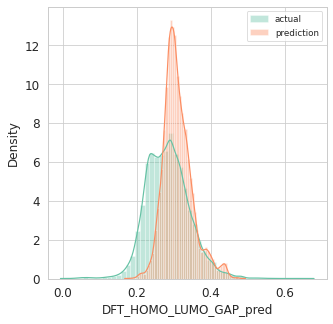

In [292]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(scaffoldecfp_results_df.DFT_HOMO_LUMO_GAP, ax=ax, label = 'actual')
sns.distplot(scaffoldecfp_results_df.DFT_HOMO_LUMO_GAP_pred, ax=ax, label = 'prediction')
plt.legend();

Below we could review the results by computing $r^{2}$ of each model and compare the results we previously have with QMUGS dataset.

In [298]:
r2_result = [dft_randgc_r2, dft_randecfp_r2, dft_fingergc_r2, dft_fingerecfp_r2, dft_scaffoldgc_r2, dft_scaffoldecfp_r2]
model_name = ['random graphconv', 'random ecfp', 'fingerprint graphconv', 'fingerprint ecfp', 'scaffold graphconv', 'scaffold ecfp']
for i in range(len(r2_result)):
    print(f'{model_name[i]}: {r2_result[i]:.4f}')

random graphconv: 0.4770
random ecfp: 0.5190
fingerprint graphconv: 0.5434
fingerprint ecfp: 0.4698
scaffold graphconv: 0.4698
scaffold ecfp: 0.5054


### Use AMPL for predicting DFT Gap Value. QMUGS1.1 database is the source (DFT HOMO LUMO GAP).
From previous invesitgation, the overall $r^{2}$ are concentrated around 0.5, which is less accurate than previous performance on QMUGS. As a result, it necessary to train new model with entire dataset of QMUGS1.1. <br>
Now that we have a curated dataset, we decide what type of featurizer and model we would like.

In this notebook, we describe the following steps using AMPL:
1.   Read a ML ready dataset
2.   Fit a Graph Convolutional model
3.   Predict pIC50 values of withheld compounds

In [4]:
import atomsci.ddm.pipeline.compare_models as cmp
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as pars

2024-03-14 21:11:55,039 Model tracker client not supported in your environment; can look at models in filesystem only.


In [5]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

--2024-03-14 21:11:56--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh’

install_AMPL_GPU_te 100%[===================>]   1.10K  --.-KB/s    in 0s      

2024-03-14 21:11:56 (58.5 MB/s) - ‘install_AMPL_GPU_test.sh’ saved [1127/1127]

mkdir: cannot create directory ‘github’: File exists
fatal: destination path 'AMPL' already exists and is not an empty directory.
error: pathspec 'deepchem_25' did not match any file(s) known to git
patch: **** Can't create temporary file /content/github/AMPL/atomsci/ddm/pipeline/transformations.py.oJctaWm : No such file or directory
patch: **** Can't create temporary fil

In [306]:
dc.__version__

'2.7.1'

### Split config

In [446]:
!pwd

/home/jupyter


In [428]:
os.chdir('/home/jupyter/')

In [ ]:
scaffold_train_25_test_1500 = scaffold_train_25.sample(1500, random_state=0)
coconut_random_25perc_total = coconut.sample(frac=0.25, random_state=0)

In [439]:
data11 = curated_df

In [447]:
data11_10perc = data11.sample(frac=0.10, random_state=0)
data11_25perc = data11.sample(frac=0.25, random_state=0)
data11_50perc = data11.sample(frac=0.50, random_state=0)

data11_10perc.to_csv('qmugs11_10perc.csv', index=False)
data11_25perc.to_csv('qmugs11_25perc.csv', index=False)
data11_50perc.to_csv('qmugs11_50perc.csv', index=False)

We first start with 10 percent of data.

In [484]:
# first use 10percent data, NN, graphconv
split_config_10perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_10perc.csv",
"datastore": "False",
"split_only": "True",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "False",
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0005", #default learning rate
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100",
"verbose": "True",
"result_dir": "/home/jupyter/Models_1.1"
}

In [473]:
split_params_10perc = parse.wrapper(split_config_10perc)
split_model_10perc = mp.ModelPipeline(split_params_10perc)
split_uuid_10perc = split_model_10perc.split_dataset()
split_uuid_10perc

'0a535c51-5474-462e-8d50-50f9e27f4dfc'

Next, we increase the amount of data to 25percent.

In [481]:
data11_25perc.shape

(6764, 75)

In [487]:
split_config_25perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_25perc.csv",
"datastore": "False",
"split_only": "True",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "False",
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0005", #default learning rate
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100",
"verbose": "True",
"result_dir": "/home/jupyter/Models_1.1"
}

In [486]:
split_params_25perc = parse.wrapper(split_config_25perc)
split_model_25perc = mp.ModelPipeline(split_params_25perc)
split_uuid_25perc = split_model_25perc.split_dataset()
split_uuid_25perc

'4425182d-abf6-48bc-933d-fdea90fab3de'

Then, we increase the data to 50 percent.

In [503]:
data11_50perc.shape

(13528, 75)

In [504]:
split_config_50perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_50perc.csv",
"datastore": "False",
"split_only": "True",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "False",
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0005", #default learning rate
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100",
"verbose": "True",
"result_dir": "/home/jupyter/Models_1.1"
}

In [505]:
split_params_50perc = parse.wrapper(split_config_50perc)
split_model_50perc = mp.ModelPipeline(split_params_50perc)
split_uuid_50perc = split_model_50perc.split_dataset()
split_uuid_50perc

'13b4ab36-c93b-4973-8a81-158f7742dbbb'

Furthermore, we use full data to train the model.

In [516]:
data11.shape

(27055, 75)

In [52]:
split_config_100perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_curated.csv",
"datastore": "False",
"split_only": "True",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "False",
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0005", #default learning rate
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100",
"verbose": "True",
"result_dir": "/home/jupyter/Models_1.1"
}

In [53]:
split_params_100perc = parse.wrapper(split_config_100perc)
split_model_100perc = mp.ModelPipeline(split_params_100perc)
split_uuid_100perc = split_model_100perc.split_dataset()
split_uuid_100perc

2024-03-20 16:05:40,507 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset_1.1/qmugs11_curated.csv'
2024-03-20 16:05:41,694 Attempting to load featurized dataset
2024-03-20 16:05:42,745 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2024-03-20 16:05:42,746 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-03-20 16:05:43,807 Featurizing sample 0
2024-03-20 16:05:46,945 Featurizing sample 1000
2024-03-20 16:05:50,088 Featurizing sample 2000
2024-03-20 16:05:53,259 Featurizing sample 3000
2024-03-20 16:05:56,379 Featurizing sample 4000
2024-03-20 16:05:59,113 Featurizing sample 5000
2024-03-20 16:06:01,926 Featurizing sample 6000
2024-03-20 16:06:04,872 Featurizing sample 7000
2024-03-20 16:06:07,771 Featurizing sample 8000
2024-03-20 16:06:10,609 Featurizing sample 9000
2024-03-20 16:06:13,513 Featurizing sample 10000
2024-03-20 16:06:16,462 

'2f66a1a5-0287-4232-b7ce-b3b4f3ba7004'

In [6]:
!pip install --upgrade gspread

In [ ]:
!date

Wed Mar 13 04:34:53 UTC 2024


### Train config

First step: 10percent of data

In [488]:
train_config_10perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_10perc.csv",
"datastore": "False",
"uncertainty": "False",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "True",
"split_uuid": "{}".format(split_uuid_10perc),
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0005", #default
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100",
"verbose": "True",
"result_dir": "/home/jupyter/Qmugs1.1_Models"
}

In [489]:
train_params_10perc = parse.wrapper(train_config_10perc)

In [490]:
train_model_10perc = mp.ModelPipeline(train_params_10perc)

In [478]:
train_model.train_model()

In [501]:
perf_df

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
0,206cb47f-b94c-451a-9a04-4fdd066cf945,/home/jupyter/Qmugs1.1_Models/qmugs11_10perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.627783,0.971334,0.010101,0.007668,1894,0.627783,0.033735,0.024608,406,0.576809,0.032348,0.024803,406,100,99,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 99, ""dropouts"": [0.0, 0.0, 0.0]...",{}


Second step: 25percent of data

In [496]:
train_config_25perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_25perc.csv",
"datastore": "False",
"uncertainty": "False",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "True",
"split_uuid": "{}".format(split_uuid_25perc),
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0005", #default
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100",
"verbose": "True",
"result_dir": "/home/jupyter/Qmugs1.1_Models"
}

In [497]:
train_params_25perc = parse.wrapper(train_config_25perc)
train_model_25perc = mp.ModelPipeline(train_params_25perc)

In [498]:
train_model_25perc.train_model()

In [502]:
perf_df = cmp.get_filesystem_perf_results('/home/jupyter/Qmugs1.1_Models', pred_type='regression')
perf_df

Found data for 2 models under /home/jupyter/Qmugs1.1_Models


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
1,19818f5b-46c1-4af7-a01c-3cbb16c5bc57,/home/jupyter/Qmugs1.1_Models/qmugs11_25perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_25perc.csv,graphconv,scaffold,r2,normalization,0.653883,0.956070,0.012362,0.009385,4734,0.653883,0.031999,0.022999,1015,0.665626,0.030629,0.022588,1015,100,76,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 76, ""dropouts"": [0.0, 0.0, 0.0]...",{}
0,206cb47f-b94c-451a-9a04-4fdd066cf945,/home/jupyter/Qmugs1.1_Models/qmugs11_10perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.627783,0.971334,0.010101,0.007668,1894,0.627783,0.033735,0.024608,406,0.576809,0.032348,0.024803,406,100,99,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 99, ""dropouts"": [0.0, 0.0, 0.0]...",{}


Third step: 50percent of data

In [506]:
train_config_50perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_50perc.csv",
"datastore": "False",
"uncertainty": "False",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "True",
"split_uuid": "{}".format(split_uuid_50perc),
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0005", #default
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100", #stop after xx no chagne
"verbose": "True",
"result_dir": "/home/jupyter/Qmugs1.1_Models"
}

In [507]:
train_params_50perc = parse.wrapper(train_config_50perc)
train_model_50perc = mp.ModelPipeline(train_params_50perc)

In [510]:
train_model_50perc.train_model()

/home/jupyter/AMPL/atomsci/ddm/pipeline/model_wrapper.py:2592: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  chkpt_dict = yaml.load(chkpt_in.read())


In [514]:
perf_df = cmp.get_filesystem_perf_results('/home/jupyter/Qmugs1.1_Models', pred_type='regression')
perf_df

Found data for 3 models under /home/jupyter/Qmugs1.1_Models


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
1,b288c487-aa36-4994-ae44-4b030420b5f3,/home/jupyter/Qmugs1.1_Models/qmugs11_50perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_50perc.csv,graphconv,scaffold,r2,normalization,0.717305,0.958508,0.011885,0.008900,9469,0.717305,0.028597,0.020634,2029,0.738611,0.027680,0.020243,2030,100,94,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 94, ""dropouts"": [0.0, 0.0, 0.0]...",{}
2,19818f5b-46c1-4af7-a01c-3cbb16c5bc57,/home/jupyter/Qmugs1.1_Models/qmugs11_25perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_25perc.csv,graphconv,scaffold,r2,normalization,0.653883,0.956070,0.012362,0.009385,4734,0.653883,0.031999,0.022999,1015,0.665626,0.030629,0.022588,1015,100,76,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 76, ""dropouts"": [0.0, 0.0, 0.0]...",{}
0,206cb47f-b94c-451a-9a04-4fdd066cf945,/home/jupyter/Qmugs1.1_Models/qmugs11_10perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.627783,0.971334,0.010101,0.007668,1894,0.627783,0.033735,0.024608,406,0.576809,0.032348,0.024803,406,100,99,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 99, ""dropouts"": [0.0, 0.0, 0.0]...",{}


Final step: 100percent of data

In [54]:
train_config_100perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_curated.csv",
"datastore": "False",
"uncertainty": "False",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "True",
"split_uuid": "{}".format(split_uuid_100perc),
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0005", #default
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100",
"verbose": "True",
"result_dir": "/home/jupyter/Qmugs1.1_Models"
}

In [55]:
train_params_100perc = parse.wrapper(train_config_100perc)
train_model_100perc = mp.ModelPipeline(train_params_100perc)

2024-03-20 16:08:14,350 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset_1.1/qmugs11_curated.csv'


In [56]:
train_model_100perc.train_model()

2024-03-20 16:08:17,298 Attempting to load featurized dataset
2024-03-20 16:08:18,358 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2024-03-20 16:08:18,359 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-03-20 16:08:19,438 Featurizing sample 0
2024-03-20 16:08:22,569 Featurizing sample 1000
2024-03-20 16:08:25,617 Featurizing sample 2000
2024-03-20 16:08:28,770 Featurizing sample 3000
2024-03-20 16:08:31,845 Featurizing sample 4000
2024-03-20 16:08:34,747 Featurizing sample 5000
2024-03-20 16:08:37,572 Featurizing sample 6000
2024-03-20 16:08:40,549 Featurizing sample 7000
2024-03-20 16:08:43,577 Featurizing sample 8000
2024-03-20 16:08:46,540 Featurizing sample 9000
2024-03-20 16:08:49,499 Featurizing sample 10000
2024-03-20 16:08:52,458 Featurizing sample 11000
2024-03-20 16:08:55,378 Featurizing sample 12000
2024-03-20 16:08:58,409 Featurizing sample 13000
2024-03-20 16:09:01,510 

In [57]:
perf_df = cmp.get_filesystem_perf_results('/home/jupyter/Qmugs1.1_Models', pred_type='regression')
perf_df

2024-03-20 16:35:36,939 Warning: column names have been changed to align with get_multitask_perf_from_tracker(): featurizer is now features and <subset>_<metric> has been changed to best_<subset>_<metric>.


Found data for 5 models under /home/jupyter/Qmugs1.1_Models


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
2,28632bbd-f587-4070-8907-2dcc7a9fdf9b,/home/jupyter/Qmugs1.1_Models/qmugs11_curated_...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.759486,0.963190,0.011298,0.008399,18938,0.759486,0.025961,0.018590,4058,0.753251,0.026572,0.019292,4059,100,92,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 92, ""dropouts"": [0.0, 0.0, 0.0]...",{}
3,4ecc873d-1e99-4d99-95cd-599a8efd5519,/home/jupyter/Qmugs1.1_Models/qmugs11_curated_...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.745944,0.959344,0.011873,0.008685,18938,0.745944,0.026682,0.018945,4058,0.740431,0.027253,0.020109,4059,100,85,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 85, ""dropouts"": [0.0, 0.0, 0.0]...",{}
1,b288c487-aa36-4994-ae44-4b030420b5f3,/home/jupyter/Qmugs1.1_Models/qmugs11_50perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_50perc.csv,graphconv,scaffold,r2,normalization,0.717305,0.958508,0.011885,0.008900,9469,0.717305,0.028597,0.020634,2029,0.738611,0.027680,0.020243,2030,100,94,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 94, ""dropouts"": [0.0, 0.0, 0.0]...",{}
4,19818f5b-46c1-4af7-a01c-3cbb16c5bc57,/home/jupyter/Qmugs1.1_Models/qmugs11_25perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_25perc.csv,graphconv,scaffold,r2,normalization,0.653883,0.956070,0.012362,0.009385,4734,0.653883,0.031999,0.022999,1015,0.665626,0.030629,0.022588,1015,100,76,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 76, ""dropouts"": [0.0, 0.0, 0.0]...",{}
0,206cb47f-b94c-451a-9a04-4fdd066cf945,/home/jupyter/Qmugs1.1_Models/qmugs11_10perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.627783,0.971334,0.010101,0.007668,1894,0.627783,0.033735,0.024608,406,0.576809,0.032348,0.024803,406,100,99,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 99, ""dropouts"": [0.0, 0.0, 0.0]...",{}


### self test 

In [ ]:
# first use 10percent data, NN, graphconv
test_split_config_10perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_10perc.csv",
"datastore": "False",
"split_only": "True",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "False",
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0007", #default learning rate
"layer_sizes": "64,64,128",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "250",
"verbose": "True",
"result_dir": "/home/jupyter/test_models"
}

In [ ]:
test_split_params_10perc = parse.wrapper(test_split_config_10perc)
test_split_model_10perc = mp.ModelPipeline(test_split_params_10perc)
test_split_uuid_10perc = test_split_model_10perc.split_dataset()

2024-03-20 14:47:33,112 Created a dataset hash '76410ddf82f87233222913b4e271bc6f' from dataset_key '/home/jupyter/dataset_1.1/qmugs11_10perc.csv'


TypeError: object of type 'NoneType' has no len()

In [37]:
test_split_uuid_10perc

'ec2ff2d0-ffec-4d5d-9b36-a21e71f7670a'

In [38]:
# max epoch to 250, add early stopping
test_train_config_10perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_10perc.csv",
"datastore": "False",
"uncertainty": "False",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "True",
"split_uuid": "{}".format(test_split_uuid_10perc),
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0007", #default
"layer_sizes": "64,64,128",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "250",
"early_stopping_patience": "50",
"verbose": "True",
"result_dir": "/home/jupyter/test_models"
}

In [39]:
test_train_params_10perc = parse.wrapper(test_train_config_10perc)
test_train_model_10perc = mp.ModelPipeline(test_train_params_10perc)

2024-03-20 14:49:33,925 Created a dataset hash '76410ddf82f87233222913b4e271bc6f' from dataset_key '/home/jupyter/dataset_1.1/qmugs11_10perc.csv'


In [40]:
test_train_model_10perc.train_model()

2024-03-20 14:49:35,636 Attempting to load featurized dataset
2024-03-20 14:49:35,785 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2024-03-20 14:49:35,786 Featurized dataset not previously saved for dataset qmugs11_10perc, creating new
2024-03-20 14:49:35,930 Featurizing sample 0
2024-03-20 14:49:39,257 Featurizing sample 1000
2024-03-20 14:49:42,509 Featurizing sample 2000
2024-03-20 14:49:44,681 Number of features: 75
2024-03-20 14:49:44,707 Previous dataset split restored
2024-03-20 14:49:44,730 Wrote transformers to /home/jupyter/test_models/qmugs11_10perc/NN_graphconv_scaffold_regression/1ed8c671-4062-4d85-b7ea-259ffc545c30/transformers.pkl
2024-03-20 14:49:44,731 Transforming response data
2024-03-20 14:49:44,733 Transforming response data
2024-03-20 14:49:44,734 Transforming response data
2024-03-20 14:50:06,201 Total score for epoch 0 is -0.977
2024-03-20 14:50:06,301 Epoch 0: training r2_score = -0.718, validati

In [41]:
test_perf_df = cmp.get_filesystem_perf_results('/home/jupyter/test_models', pred_type='regression')
test_perf_df

2024-03-20 14:54:10,636 Warning: column names have been changed to align with get_multitask_perf_from_tracker(): featurizer is now features and <subset>_<metric> has been changed to best_<subset>_<metric>.


Found data for 3 models under /home/jupyter/test_models


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
2,1ed8c671-4062-4d85-b7ea-259ffc545c30,/home/jupyter/test_models/qmugs11_10perc_model...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.681725,0.980163,0.008402,0.006647,1894,0.681725,0.031195,0.022707,406,0.574062,0.032453,0.024627,406,250,99,0.0007,"64,64,128","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 99, ""dropouts"": [0.0, 0.0, 0.0]...",{}
0,fed5f382-f37d-4e18-a541-b0497fdec357,/home/jupyter/test_models/qmugs11_10perc_model...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.661722,0.972437,0.009904,0.007483,1894,0.661722,0.032160,0.024050,406,0.553082,0.033243,0.024919,406,250,121,0.0007,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 121, ""dropouts"": [0.0, 0.0, 0.0...",{}
1,67b29248-7af3-4b64-9752-25ee6a5c510c,/home/jupyter/test_models/qmugs11_10perc_model...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.650332,0.962675,0.011526,0.008693,1894,0.650332,0.032697,0.025089,406,0.543015,0.033615,0.025526,406,250,74,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 74, ""dropouts"": [0.0, 0.0, 0.0]...",{}


test for 50% data, see if there are improvements, use same config

In [42]:
# first use 10percent data, NN, graphconv
test_split_config_50perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_50perc.csv",
"datastore": "False",
"split_only": "True",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "False",
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0007", #default learning rate
"layer_sizes": "64,64,128",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "250",
"verbose": "True",
"result_dir": "/home/jupyter/test_models"
}

In [45]:
test_split_params_50perc = parse.wrapper(test_split_config_50perc)
test_split_model_50perc = mp.ModelPipeline(test_split_params_50perc)
test_split_uuid_50perc = test_split_model_50perc.split_dataset()

2024-03-20 15:17:37,864 Created a dataset hash 'be57f7009e884094e5a4bd3eeb428c4d' from dataset_key '/home/jupyter/dataset_1.1/qmugs11_50perc.csv'
2024-03-20 15:17:38,536 Attempting to load featurized dataset
2024-03-20 15:17:39,099 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2024-03-20 15:17:39,100 Featurized dataset not previously saved for dataset qmugs11_50perc, creating new
2024-03-20 15:17:39,660 Featurizing sample 0
2024-03-20 15:17:43,191 Featurizing sample 1000
2024-03-20 15:17:46,250 Featurizing sample 2000
2024-03-20 15:17:49,304 Featurizing sample 3000
2024-03-20 15:17:52,399 Featurizing sample 4000
2024-03-20 15:17:55,483 Featurizing sample 5000
2024-03-20 15:17:58,403 Featurizing sample 6000
2024-03-20 15:18:01,380 Featurizing sample 7000
2024-03-20 15:18:04,984 Featurizing sample 8000
2024-03-20 15:18:08,053 Featurizing sample 9000
2024-03-20 15:18:11,069 Featurizing sample 10000
2024-03-20 15:18:14,182 Fe

In [46]:
test_split_uuid_50perc

'458e2a3d-0949-4962-83bc-a770fbb86bfa'

In [47]:
# max epoch to 250, add early stopping
test_train_config_50perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_50perc.csv",
"datastore": "False",
"uncertainty": "False",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "True",
"split_uuid": "{}".format(test_split_uuid_50perc),
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0007",
"layer_sizes": "64,64,128",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "250",
"early_stopping_patience": "50",
"verbose": "True",
"result_dir": "/home/jupyter/test_models"
}

In [48]:
test_train_params_50perc = parse.wrapper(test_train_config_50perc)
test_train_model_50perc = mp.ModelPipeline(test_train_params_50perc)

2024-03-20 15:20:10,033 Created a dataset hash 'be57f7009e884094e5a4bd3eeb428c4d' from dataset_key '/home/jupyter/dataset_1.1/qmugs11_50perc.csv'


In [49]:
test_train_model_50perc.train_model()

2024-03-20 15:20:11,625 Attempting to load featurized dataset
2024-03-20 15:20:12,224 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2024-03-20 15:20:12,225 Featurized dataset not previously saved for dataset qmugs11_50perc, creating new
2024-03-20 15:20:12,775 Featurizing sample 0
2024-03-20 15:20:16,394 Featurizing sample 1000
2024-03-20 15:20:19,609 Featurizing sample 2000
2024-03-20 15:20:22,901 Featurizing sample 3000
2024-03-20 15:20:26,032 Featurizing sample 4000
2024-03-20 15:20:29,128 Featurizing sample 5000
2024-03-20 15:20:32,214 Featurizing sample 6000
2024-03-20 15:20:35,358 Featurizing sample 7000
2024-03-20 15:20:38,399 Featurizing sample 8000
2024-03-20 15:20:41,532 Featurizing sample 9000
2024-03-20 15:20:44,561 Featurizing sample 10000
2024-03-20 15:20:47,576 Featurizing sample 11000
2024-03-20 15:20:50,589 Featurizing sample 12000
2024-03-20 15:20:53,702 Featurizing sample 13000
2024-03-20 15:20:55,427 N

train the model using full dataset

In [59]:
# first use 10percent data, NN, graphconv
test_split_config_100perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_curated.csv",
"datastore": "False",
"split_only": "True",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "False",
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0007", #default learning rate
"layer_sizes": "64,64,128",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "250",
"verbose": "True",
"result_dir": "/home/jupyter/test_models"
}

In [60]:
test_split_params_100perc = parse.wrapper(test_split_config_100perc)
test_split_model_100perc = mp.ModelPipeline(test_split_params_100perc)
test_split_uuid_100perc = test_split_model_100perc.split_dataset()

2024-03-20 16:48:34,798 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset_1.1/qmugs11_curated.csv'
2024-03-20 16:48:36,036 Attempting to load featurized dataset
2024-03-20 16:48:37,090 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2024-03-20 16:48:37,091 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-03-20 16:48:38,158 Featurizing sample 0
2024-03-20 16:48:41,409 Featurizing sample 1000
2024-03-20 16:48:44,517 Featurizing sample 2000
2024-03-20 16:48:47,690 Featurizing sample 3000
2024-03-20 16:48:50,774 Featurizing sample 4000
2024-03-20 16:48:55,476 Featurizing sample 5000
2024-03-20 16:48:58,187 Featurizing sample 6000
2024-03-20 16:49:00,981 Featurizing sample 7000
2024-03-20 16:49:04,041 Featurizing sample 8000
2024-03-20 16:49:06,925 Featurizing sample 9000
2024-03-20 16:49:09,815 Featurizing sample 10000
2024-03-20 16:49:12,687 

In [61]:
test_split_uuid_100perc

'e889b606-fab8-45b1-9345-e38c684eeabe'

In [62]:
# max epoch to 250, add early stopping
test_train_config_100perc = {
"script_dir": "/home/jupyter/AMPL/atomsci/ddm",
"dataset_key" : "/home/jupyter/dataset_1.1/qmugs11_curated.csv",
"datastore": "False",
"uncertainty": "False",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "True",
"split_uuid": "{}".format(test_split_uuid_100perc),
"prediction_type": "regression",
"response_cols" : "DFT_HOMO_LUMO_GAP",
"id_col": "compound_id",
"smiles_col" : "rdkit_smiles",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0007",
"layer_sizes": "64,64,128",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "250",
"early_stopping_patience": "50",
"verbose": "True",
"result_dir": "/home/jupyter/test_models"
}

In [63]:
test_train_params_100perc = parse.wrapper(test_train_config_100perc)
test_train_model_100perc = mp.ModelPipeline(test_train_params_100perc)

2024-03-20 16:53:54,782 Created a dataset hash 'd439e5e84250ccc79aee812d3d773a20' from dataset_key '/home/jupyter/dataset_1.1/qmugs11_curated.csv'


In [64]:
test_train_model_100perc.train_model()

2024-03-20 16:53:58,044 Attempting to load featurized dataset
2024-03-20 16:53:59,084 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2024-03-20 16:53:59,085 Featurized dataset not previously saved for dataset qmugs11_curated, creating new
2024-03-20 16:54:00,141 Featurizing sample 0
2024-03-20 16:54:03,174 Featurizing sample 1000
2024-03-20 16:54:06,185 Featurizing sample 2000
2024-03-20 16:54:09,227 Featurizing sample 3000
2024-03-20 16:54:12,194 Featurizing sample 4000
2024-03-20 16:54:14,894 Featurizing sample 5000
2024-03-20 16:54:17,614 Featurizing sample 6000
2024-03-20 16:54:20,686 Featurizing sample 7000
2024-03-20 16:54:23,686 Featurizing sample 8000
2024-03-20 16:54:26,549 Featurizing sample 9000
2024-03-20 16:54:29,486 Featurizing sample 10000
2024-03-20 16:54:32,402 Featurizing sample 11000
2024-03-20 16:54:35,444 Featurizing sample 12000
2024-03-20 16:54:38,614 Featurizing sample 13000
2024-03-20 16:54:41,828 

In [65]:
test_perf_df = cmp.get_filesystem_perf_results('/home/jupyter/test_models', pred_type='regression')
test_perf_df

2024-03-20 17:29:20,042 Warning: column names have been changed to align with get_multitask_perf_from_tracker(): featurizer is now features and <subset>_<metric> has been changed to best_<subset>_<metric>.


Found data for 5 models under /home/jupyter/test_models


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
4,c125adad-b26e-472e-9440-667f7a101389,/home/jupyter/test_models/qmugs11_curated_mode...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.784685,0.970802,0.010062,0.007432,18938,0.784685,0.024563,0.017363,4058,0.781938,0.024979,0.018079,4059,250,76,0.0007,"64,64,128","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 76, ""dropouts"": [0.0, 0.0, 0.0]...",{}
3,fd60cfc1-6799-4b18-b26e-29688fcb71e7,/home/jupyter/test_models/qmugs11_50perc_model...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_50perc.csv,graphconv,scaffold,r2,normalization,0.759491,0.981603,0.007914,0.006058,9469,0.759491,0.026377,0.019191,2029,0.746273,0.027271,0.019762,2030,250,153,0.0007,"64,64,128","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 153, ""dropouts"": [0.0, 0.0, 0.0...",{}
2,1ed8c671-4062-4d85-b7ea-259ffc545c30,/home/jupyter/test_models/qmugs11_10perc_model...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.681725,0.980163,0.008402,0.006647,1894,0.681725,0.031195,0.022707,406,0.574062,0.032453,0.024627,406,250,99,0.0007,"64,64,128","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 99, ""dropouts"": [0.0, 0.0, 0.0]...",{}
0,fed5f382-f37d-4e18-a541-b0497fdec357,/home/jupyter/test_models/qmugs11_10perc_model...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.661722,0.972437,0.009904,0.007483,1894,0.661722,0.032160,0.024050,406,0.553082,0.033243,0.024919,406,250,121,0.0007,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 121, ""dropouts"": [0.0, 0.0, 0.0...",{}
1,67b29248-7af3-4b64-9752-25ee6a5c510c,/home/jupyter/test_models/qmugs11_10perc_model...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.650332,0.962675,0.011526,0.008693,1894,0.650332,0.032697,0.025089,406,0.543015,0.033615,0.025526,406,250,74,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 74, ""dropouts"": [0.0, 0.0, 0.0]...",{}


In [58]:
perf_df

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
2,28632bbd-f587-4070-8907-2dcc7a9fdf9b,/home/jupyter/Qmugs1.1_Models/qmugs11_curated_...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.759486,0.963190,0.011298,0.008399,18938,0.759486,0.025961,0.018590,4058,0.753251,0.026572,0.019292,4059,100,92,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 92, ""dropouts"": [0.0, 0.0, 0.0]...",{}
3,4ecc873d-1e99-4d99-95cd-599a8efd5519,/home/jupyter/Qmugs1.1_Models/qmugs11_curated_...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_curated.csv,graphconv,scaffold,r2,normalization,0.745944,0.959344,0.011873,0.008685,18938,0.745944,0.026682,0.018945,4058,0.740431,0.027253,0.020109,4059,100,85,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 85, ""dropouts"": [0.0, 0.0, 0.0]...",{}
1,b288c487-aa36-4994-ae44-4b030420b5f3,/home/jupyter/Qmugs1.1_Models/qmugs11_50perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_50perc.csv,graphconv,scaffold,r2,normalization,0.717305,0.958508,0.011885,0.008900,9469,0.717305,0.028597,0.020634,2029,0.738611,0.027680,0.020243,2030,100,94,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 94, ""dropouts"": [0.0, 0.0, 0.0]...",{}
4,19818f5b-46c1-4af7-a01c-3cbb16c5bc57,/home/jupyter/Qmugs1.1_Models/qmugs11_25perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_25perc.csv,graphconv,scaffold,r2,normalization,0.653883,0.956070,0.012362,0.009385,4734,0.653883,0.031999,0.022999,1015,0.665626,0.030629,0.022588,1015,100,76,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 76, ""dropouts"": [0.0, 0.0, 0.0]...",{}
0,206cb47f-b94c-451a-9a04-4fdd066cf945,/home/jupyter/Qmugs1.1_Models/qmugs11_10perc_m...,1.5.1,NN,/home/jupyter/dataset_1.1/qmugs11_10perc.csv,graphconv,scaffold,r2,normalization,0.627783,0.971334,0.010101,0.007668,1894,0.627783,0.033735,0.024608,406,0.576809,0.032348,0.024803,406,100,99,0.0005,"64,64,32","0.00,0.00,0.00",NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 99, ""dropouts"": [0.0, 0.0, 0.0]...",{}


Loss Curves: Plot training vs. validation loss over epochs to identify overfitting.

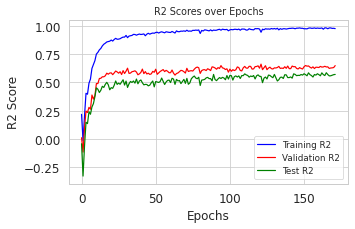

In [34]:
training_r2 = [
    0.218, -0.016, 0.204, 0.404, 0.396, 0.493, 0.530, 0.624, 0.658, 0.693, 
    0.751, 0.766, 0.788, 0.801, 0.823, 0.838, 0.847, 0.858, 0.862, 0.865, 
    0.875, 0.866, 0.880, 0.890, 0.882, 0.883, 0.887, 0.895, 0.901, 0.901, 
    0.916, 0.896, 0.910, 0.913, 0.916, 0.925, 0.924, 0.918, 0.924, 0.928, 
    0.924, 0.926, 0.929, 0.913, 0.927, 0.935, 0.927, 0.933, 0.937, 0.935, 
    0.942, 0.944, 0.937, 0.944, 0.948, 0.943, 0.939, 0.948, 0.945, 0.943, 
    0.942, 0.951, 0.944, 0.937, 0.956, 0.949, 0.949, 0.954, 0.953, 0.956, 
    0.952, 0.962, 0.953, 0.955, 0.953, 0.961, 0.960, 0.963, 0.961, 0.964, 
    0.933, 0.960, 0.955, 0.965, 0.963, 0.959, 0.956, 0.965, 0.956, 0.963, 
    0.961, 0.962, 0.967, 0.970, 0.962, 0.971, 0.968, 0.967, 0.969, 0.957, 
    0.965, 0.968, 0.966, 0.970, 0.970, 0.967, 0.972, 0.962, 0.972, 0.972, 
    0.971, 0.963, 0.964, 0.975, 0.969, 0.967, 0.965, 0.976, 0.975, 0.976, 
    0.972, 0.944, 0.971, 0.966, 0.975, 0.972, 0.973, 0.971, 0.977, 0.973, 
    0.977, 0.972, 0.979, 0.965, 0.976, 0.970, 0.975, 0.975, 0.972, 0.975, 
    0.978, 0.978, 0.980, 0.979, 0.975, 0.980, 0.980, 0.982, 0.979, 0.979, 
    0.975, 0.975, 0.974, 0.980, 0.982, 0.979, 0.979, 0.982, 0.978, 0.981, 
    0.979, 0.979, 0.982, 0.971, 0.983, 0.982, 0.975, 0.982, 0.982, 0.978, 
    0.979, 0.976
]

validation_r2 = [
    0.011, -0.116, 0.100, 0.247, 0.234, 0.280, 0.263, 0.389, 0.353, 0.384, 
    0.490, 0.490, 0.535, 0.537, 0.550, 0.550, 0.559, 0.582, 0.573, 0.583, 
    0.585, 0.569, 0.584, 0.601, 0.593, 0.582, 0.595, 0.570, 0.605, 0.579, 
    0.600, 0.626, 0.580, 0.583, 0.595, 0.598, 0.603, 0.592, 0.568, 0.576, 
    0.589, 0.618, 0.578, 0.596, 0.575, 0.582, 0.571, 0.576, 0.598, 0.590, 
    0.617, 0.572, 0.584, 0.597, 0.606, 0.614, 0.596, 0.607, 0.599, 0.586, 
    0.586, 0.610, 0.582, 0.565, 0.579, 0.584, 0.595, 0.607, 0.604, 0.595, 
    0.583, 0.625, 0.597, 0.602, 0.604, 0.601, 0.617, 0.630, 0.636, 0.630, 
    0.580, 0.605, 0.612, 0.613, 0.605, 0.621, 0.615, 0.605, 0.638, 0.635, 
    0.628, 0.617, 0.631, 0.624, 0.649, 0.629, 0.625, 0.614, 0.621, 0.591, 
    0.618, 0.599, 0.613, 0.605, 0.612, 0.637, 0.632, 0.606, 0.602, 0.629, 
    0.642, 0.627, 0.626, 0.643, 0.642, 0.618, 0.620, 0.640, 0.641, 0.647, 
    0.626, 0.662, 0.613, 0.631, 0.648, 0.613, 0.627, 0.635, 0.622, 0.619, 
    0.629, 0.628, 0.632, 0.642, 0.624, 0.627, 0.624, 0.639, 0.625, 0.645, 
    0.622, 0.622, 0.645, 0.639, 0.640, 0.624, 0.619, 0.631, 0.624, 0.619, 
    0.639, 0.650, 0.644, 0.646, 0.635, 0.627, 0.638, 0.623, 0.635, 0.634, 
    0.632, 0.642, 0.636, 0.637, 0.643, 0.637, 0.638, 0.624, 0.628, 0.629, 
    0.632, 0.649
]

test_r2 = [
    -0.042, -0.328, -0.062, 0.148, 0.136, 0.241, 0.219, 0.283, 0.313, 0.374, 
    0.452, 0.440, 0.411, 0.431, 0.466, 0.456, 0.483, 0.501, 0.480, 0.435, 
    0.454, 0.448, 0.475, 0.513, 0.483, 0.494, 0.484, 0.504, 0.524, 0.477, 
    0.512, 0.456, 0.488, 0.509, 0.500, 0.513, 0.494, 0.530, 0.488, 0.513, 
    0.522, 0.497, 0.479, 0.483, 0.482, 0.470, 0.476, 0.497, 0.513, 0.461, 
    0.508, 0.504, 0.500, 0.508, 0.539, 0.510, 0.482, 0.504, 0.518, 0.521, 
    0.499, 0.537, 0.530, 0.483, 0.527, 0.514, 0.517, 0.490, 0.509, 0.527, 
    0.492, 0.536, 0.484, 0.496, 0.532, 0.547, 0.557, 0.539, 0.533, 0.546, 
    0.473, 0.521, 0.523, 0.527, 0.540, 0.545, 0.534, 0.534, 0.514, 0.571, 
    0.526, 0.516, 0.531, 0.543, 0.535, 0.545, 0.539, 0.524, 0.561, 0.530, 
    0.562, 0.560, 0.521, 0.551, 0.558, 0.548, 0.558, 0.535, 0.561, 0.560, 
    0.576, 0.567, 0.562, 0.547, 0.557, 0.552, 0.561, 0.531, 0.559, 0.567, 
    0.554, 0.553, 0.498, 0.538, 0.548, 0.531, 0.565, 0.562, 0.551, 0.542, 
    0.571, 0.543, 0.513, 0.524, 0.545, 0.547, 0.535, 0.568, 0.567, 0.543, 
    0.543, 0.549, 0.538, 0.576, 0.571, 0.560, 0.563, 0.562, 0.570, 0.565, 
    0.577, 0.569, 0.559, 0.585, 0.569, 0.561, 0.548, 0.570, 0.565, 0.577, 
    0.569, 0.559, 0.585, 0.569, 0.561, 0.586, 0.570, 0.558, 0.559, 0.564, 
    0.569, 0.571
]

epochs = list(range(172))

plt.figure(figsize=(5, 3))
plt.plot(epochs, training_r2, 'b-', label='Training R2')
plt.plot(epochs, validation_r2, 'r-', label='Validation R2')
plt.plot(epochs, test_r2, 'g-', label='Test R2')
plt.title('R2 Scores over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()